<a href="https://colab.research.google.com/github/Angelicogfa/analise_fraude/blob/master/04-modelagem_preditiva.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modelagem Preditiva com Modelos Baseados em Contagem

Esse notebook tem como objetivo analisar os dados transacionais agrupados, em janelas de 15 minutos, e avaliar as caracteristicas que podem influênciar na quantidade de contagem de fraudes.

## 1. Importação de bibliotecas e Dados

In [289]:
%pip install statstests

In [290]:
# Bibliotecas para Análise
import os
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
from warnings import filterwarnings
from matplotlib import pyplot as plt

# Bibliotecas para StepWise
from tqdm import tqdm
from sklearn.exceptions import NotFittedError
from sklearn.utils import check_array, check_X_y
from sklearn.base import BaseEstimator, TransformerMixin

# Bibliotecas para Modelagem
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statstests.tests import overdisp
from scipy.stats import poisson, nbinom
from statstests.process import stepwise
from statsmodels.iolib.summary2 import summary_col
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, root_mean_squared_error
from statsmodels.discrete.discrete_model import NegativeBinomial, Poisson
from statsmodels.discrete.count_model import ZeroInflatedNegativeBinomialP,ZeroInflatedPoisson

filterwarnings('ignore')

In [291]:
if 'google.colab' in str(get_ipython()):
  from google.colab import drive

  os.makedirs('./datasets', exist_ok=True)
  drive.mount('/content/drive')

  shutil.copy('/content/drive/MyDrive/DataScience/Analytics/Estudo Fraude/transactions_features.parquet','/content/datasets/')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [292]:
df = pd.read_parquet('/content/datasets/transactions_features.parquet')

## 2. Análise e Modelagem Preditiva com Modelos de Contagem

In [293]:
df.head()

date_window  transactions  frauds  mean_amount  std_amount  \
0 2010-01-01 00:00:00           945       0    35.946466   57.952338   
1 2010-01-01 12:00:00          1246       1    52.791172   74.982758   
2 2010-01-02 00:00:00           790       0    54.026468  101.266420   
3 2010-01-02 12:00:00          1099       0    52.328399   63.104872   
4 2010-01-03 00:00:00           960       0    42.451219   61.013997   

   skew_amount  kurtosis_amount  mean_current_age  std_current_age  \
0     8.632234       147.146700         55.446561        15.046663   
1     7.182470        85.462344         55.994382        15.715262   
2     7.614952        76.651550         55.384810        15.203271   
3     5.249532        48.875334         55.169245        15.115057   
4     4.805916        38.472036         54.342708        15.171946   

   skew_current_age  ...  category_retail_home_garden  \
0          0.585560  ...                         0.01   
1          0.560368  ...                         0.01   
2          0.571805  ...                         0.04   
3          0.658781  ...                         0.03   
4          0.637759  ...                         0.03   

   category_retail_general_department  category_technology_telecommunications  \
0                                0.05                                    0.02   
1                                0.05                                    0.02   
2                                0.13                                    0.03   
3                                0.13                                    0.03   
4                                0.09                                    0.03   

   category_travel_hospitality  category_arts_entertainment_recreation  \
0                          0.0                                    0.02   
1                          0.0                                    0.05   
2                          0.0                                    0.01   
3                          0.0                                    0.05   
4                          0.0                                    0.01   

   category_health_medical  category_financial_insurance  \
0                     0.04                          0.05   
1                     0.03                          0.05   
2                     0.06                          0.05   
3                     0.06                          0.06   
4                     0.08                          0.04   

   category_retail_clothing_accessories  category_food_beverage  \
0                                  0.00                    0.48   
1                                  0.01                    0.47   
2                                  0.01                    0.35   
3                                  0.00                    0.32   
4                                  0.01                    0.40   

   category_personal_services  
0                        0.00  
1                        0.00  
2                        0.01  
3                        0.01  
4                        0.01  

[5 rows x 61 columns]

In [294]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7182 entries, 0 to 7181
Data columns (total 61 columns):
 #   Column                                   Non-Null Count  Dtype         
---  ------                                   --------------  -----         
 0   date_window                              7182 non-null   datetime64[ns]
 1   transactions                             7182 non-null   uint32        
 2   frauds                                   7182 non-null   int32         
 3   mean_amount                              7182 non-null   float64       
 4   std_amount                               7182 non-null   float64       
 5   skew_amount                              7182 non-null   float64       
 6   kurtosis_amount                          7182 non-null   float64       
 7   mean_current_age                         7182 non-null   float64       
 8   std_current_age                          7182 non-null   float64       
 9   skew_current_age                         

In [295]:
df.describe()

date_window  transactions       frauds  mean_amount  \
count                           7182   7182.000000  7182.000000  7182.000000   
mean   2014-12-01 05:59:59.999999744   1179.641326     1.788081    50.500858   
min              2010-01-01 00:00:00      2.000000     0.000000    33.413287   
25%              2012-06-16 15:00:00   1110.250000     0.000000    43.590483   
50%              2014-12-01 06:00:00   1196.000000     0.000000    51.681715   
75%              2017-05-16 21:00:00   1297.000000     2.000000    55.663921   
max              2019-10-31 12:00:00   1479.000000    37.000000  1153.310000   
std                              NaN    144.070030     3.338021    17.706331   

        std_amount  skew_amount  kurtosis_amount  mean_current_age  \
count  7182.000000  7182.000000      7182.000000       7182.000000   
mean     72.326611     6.301552        74.999561         54.095551   
min      24.324473     0.000000        -2.000000         33.000000   
25%      63.414798     4.694545        37.365587         53.686150   
50%      70.836905     5.911717        58.900306         54.068223   
75%      79.434175     7.392382        90.305724         54.477536   
max     494.849476    31.962922      1109.560815         62.230769   
std      14.661347     2.545184        69.440871          0.651121   

       std_current_age  skew_current_age  ...  category_retail_home_garden  \
count      7182.000000       7182.000000  ...                  7182.000000   
mean         15.714735          0.543517  ...                     0.026940   
min           9.899495         -0.148987  ...                     0.000000   
25%          15.450786          0.509598  ...                     0.020000   
50%          15.724837          0.543787  ...                     0.030000   
75%          15.990190          0.578872  ...                     0.030000   
max          16.997615          0.723312  ...                     0.500000   
std           0.390908          0.053724  ...                     0.009276   

       category_retail_general_department  \
count                         7182.000000   
mean                             0.104081   
min                              0.000000   
25%                              0.090000   
50%                              0.110000   
75%                              0.120000   
max                              0.150000   
std                              0.018849   

       category_technology_telecommunications  category_travel_hospitality  \
count                             7182.000000                  7182.000000   
mean                                 0.028648                     0.001422   
min                                  0.000000                     0.000000   
25%                                  0.020000                     0.000000   
50%                                  0.030000                     0.000000   
75%                                  0.030000                     0.000000   
max                                  0.330000                     0.500000   
std                                  0.007236                     0.007307   

       category_arts_entertainment_recreation  category_health_medical  \
count                             7182.000000              7182.000000   
mean                                 0.016941                 0.070216   
min                                  0.000000                 0.000000   
25%                                  0.010000                 0.070000   
50%                                  0.010000                 0.070000   
75%                                  0.020000                 0.080000   
max                                  0.070000                 0.100000   
std                                  0.016096                 0.010348   

       category_financial_insurance  category_retail_clothing_accessories  \
count                   7182.000000                           7182.000000   
mean                       0.050802     

## Implementação de Modelos

In [296]:
y = df['frauds']
X = df.drop(columns=['date_window'])

In [297]:
y.shape

(7182,)

In [298]:
y.value_counts()

frauds
0     4556
1      549
2      381
3      289
4      259
5      223
6      193
7      173
8      116
9       97
10      93
11      78
12      53
14      31
13      27
16      17
15      15
18       8
19       7
17       6
20       3
23       2
22       2
21       1
26       1
37       1
24       1
Name: count, dtype: int64

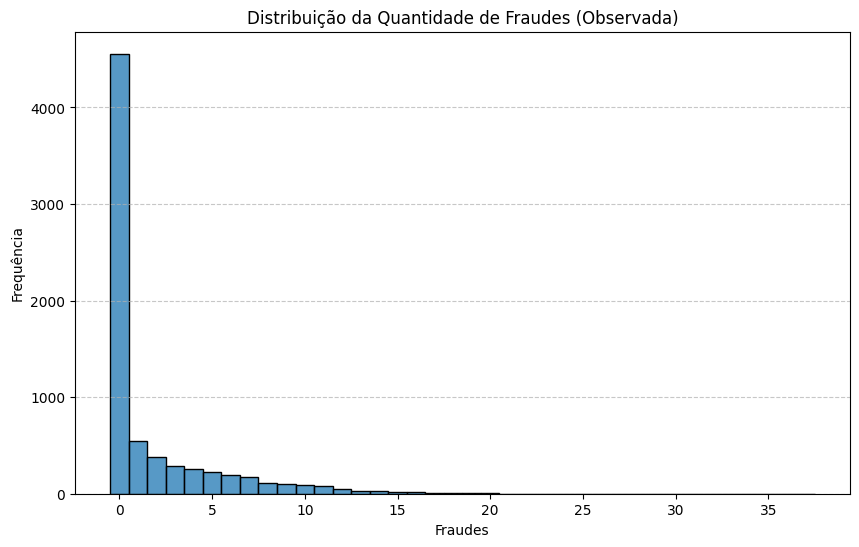

In [299]:
plt.figure(figsize=(10, 6))
sns.histplot(y, bins=range(0, int(np.max(y)) + 2), stat='count', discrete=True)
plt.title('Distribuição da Quantidade de Fraudes (Observada)')
plt.xlabel('Fraudes')
plt.ylabel('Frequência')
plt.xticks(range(0, int(np.max(y)) + 1, 5)) # Ajuste os ticks para melhor visualização
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Optimization terminated successfully.
         Current function value: 1.586140
         Iterations: 6
         Function evaluations: 7
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 1.561458
         Iterations: 29
         Function evaluations: 33
         Gradient evaluations: 33


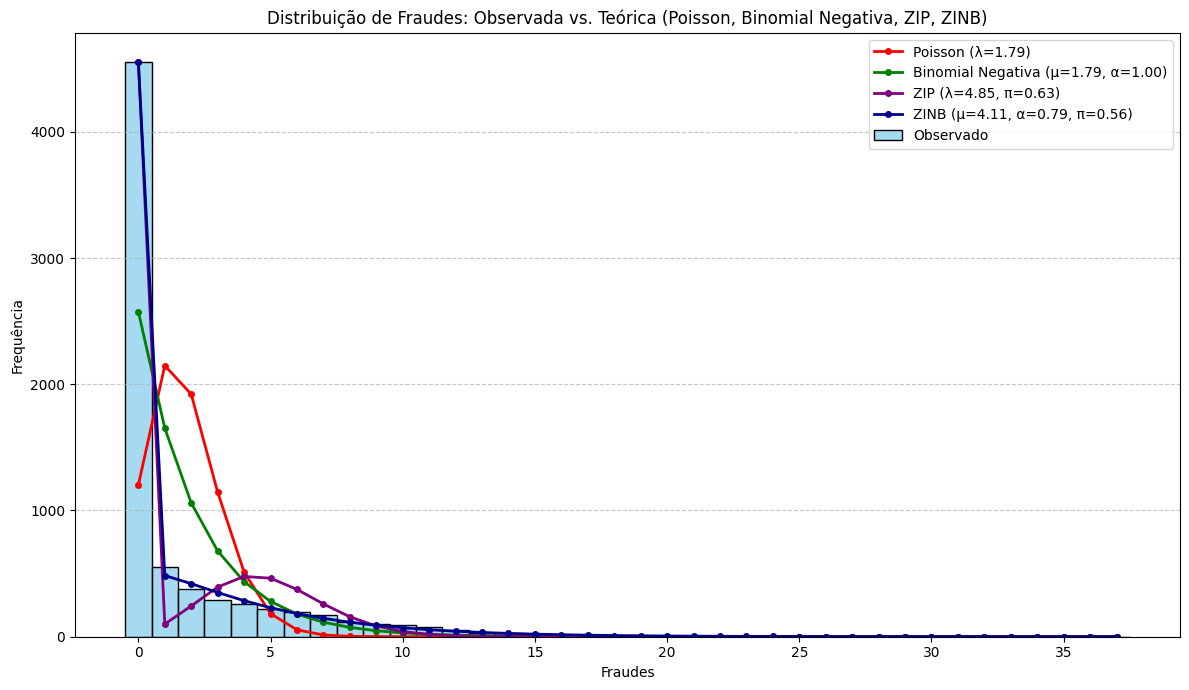

In [300]:
max_fraudes = int(np.max(y))
bins = np.arange(0, max_fraudes + 2)
df_fraudes = pd.DataFrame({'Fraudes': y})

plt.figure(figsize=(12, 7))
ax = sns.histplot(y, bins=bins, stat='count', discrete=True, color='skyblue', label='Observado')

# --- Poisson ---
lambda_poisson = np.mean(y)
poisson_pmf = poisson.pmf(bins[:-1], lambda_poisson)
poisson_freq = poisson_pmf * len(y)
ax.plot(bins[:-1], poisson_freq, 'o-', color='red', label=f'Poisson (λ={lambda_poisson:.2f})', linewidth=2, markersize=4)

# --- Binomial Negativa ---
exog = np.ones(len(y))
try:
    negbin_model = sm.NegativeBinomial.from_formula("Fraudes ~ 1", data=df_fraudes).fit(disp=True, maxiter=1000)
    mu_negbin = np.exp(negbin_model.params['Intercept'])
    alpha_negbin = negbin_model.scale

    n_param_scipy = 1 / alpha_negbin
    p_param_scipy = n_param_scipy / (n_param_scipy + mu_negbin)
    negbin_pmf = nbinom.pmf(bins[:-1], n=n_param_scipy, p=p_param_scipy)
    negbin_freq = negbin_pmf * len(y)
    ax.plot(bins[:-1], negbin_freq, 'o-', color='green', label=f'Binomial Negativa (μ={mu_negbin:.2f}, α={alpha_negbin:.2f})', linewidth=2, markersize=4)
except Exception as e:
    print(f"Não foi possível ajustar o modelo Binomial Negativa com statsmodels: {e}")
    print("Isso pode acontecer com dados muito esparsos ou se o modelo não convergir.")

# --- Zero Inflated Poisson ---
try:
    zip_model = sm.ZeroInflatedPoisson.from_formula("Fraudes ~ 1", data=df_fraudes).fit(maxiter=1000, disp=False)
    lambda_zip = np.exp(zip_model.params['Intercept'])
    pi_zip = 1 / (1 + np.exp(-zip_model.params['inflate_const'])) # Transformando o logit de volta para probabilidade

    zip_freq = np.zeros_like(bins[:-1], dtype=float)
    for k in bins[:-1]:
        if k == 0:
            # Probabilidade de ser 0 = (prob de ser zero extra) + (prob de ser 0 pelo processo Poisson normal * (1 - prob de ser zero extra))
            zip_freq[k] = (pi_zip + (1 - pi_zip) * poisson.pmf(0, lambda_zip)) * len(df_fraudes)
        else:
            # Probabilidade de ser k > 0 = (prob de ser k pelo processo Poisson normal * (1 - prob de ser zero extra))
            zip_freq[k] = (1 - pi_zip) * poisson.pmf(k, lambda_zip) * len(df_fraudes)
    ax.plot(bins[:-1], zip_freq, 'o-', color='purple', label=f'ZIP (λ={lambda_zip:.2f}, π={pi_zip:.2f})', linewidth=2, markersize=4)
except Exception as e:
    print(f"Não foi possível ajustar o modelo ZIP com statsmodels: {e}")
    print("Isso pode acontecer com dados muito esparsos ou se o modelo não convergir.")

# --- Zero Inflated Binomial Negative ---
try:
    zinb_model = sm.ZeroInflatedNegativeBinomialP.from_formula(
        "Fraudes ~ 1",
        inflation_formula="~ 1",
        data=df_fraudes
    ).fit(maxiter=1000, cov_type='HC0')

    # Parâmetros da parte Negative Binomial
    mu_zinb = np.exp(zinb_model.params['Intercept']) # Média estimada (exp de intercepto)
    alpha_zinb = zinb_model.params['alpha'] # Parâmetro de dispersão (alpha)

    # Parâmetro da parte de inflação de zeros (probabilidade de ser um zero extra)
    pi_zinb_logit = zinb_model.params['inflate_const'] # Nome do parâmetro pode variar dependendo da versão
    pi_zinb = 1 / (1 + np.exp(-pi_zinb_logit)) # Transformando logit para probabilidade

    # Calcular as frequências teóricas para o ZINB
    zinb_freq = np.zeros_like(bins[:-1], dtype=float)

    n_param_scipy_zinb = 1 / alpha_zinb
    p_param_scipy_zinb = n_param_scipy_zinb / (n_param_scipy_zinb + mu_zinb)

    for k in bins[:-1]:
        if k == 0:
            zinb_freq[k] = (pi_zinb + (1 - pi_zinb) * nbinom.pmf(0, n=n_param_scipy_zinb, p=p_param_scipy_zinb)) * len(df_fraudes)
        else:
            zinb_freq[k] = (1 - pi_zinb) * nbinom.pmf(k, n=n_param_scipy_zinb, p=p_param_scipy_zinb) * len(df_fraudes)
    ax.plot(bins[:-1], zinb_freq, 'o-', color='darkblue', label=f'ZINB (μ={mu_zinb:.2f}, α={alpha_zinb:.2f}, π={pi_zinb:.2f})', linewidth=2, markersize=4)
except Exception as e:
    print(f"Não foi possível ajustar o modelo ZINB: {e}")
    print("Verifique se a versão do statsmodels é recente o suficiente ou se os dados são muito extremos.")


plt.title('Distribuição de Fraudes: Observada vs. Teórica (Poisson, Binomial Negativa, ZIP, ZINB)')
plt.xlabel('Fraudes')
plt.ylabel('Frequência')
plt.xticks(range(0, max_fraudes + 1, 5))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()


### Métodos Auxiliares

In [301]:
def lrtest(modelos):
    modelo_1 = modelos[0]
    llk_1 = modelo_1.llnull
    llk_2 = modelo_1.llf

    if len(modelos)>1:
        llk_1 = modelo_1.llf
        llk_2 = modelos[1].llf
    LR_statistic = -2*(llk_1-llk_2)
    p_val = stats.chi2.sf(LR_statistic, 1) # 1 grau de liberdade

    print("Likelihood Ratio Test:")
    print(f"-2.(LL0-LLm): {round(LR_statistic, 2)}")
    print(f"p-value: {p_val:.3f}")
    print("")
    print("==================Result======================== \n")
    if p_val <= 0.05:
        print("H1: Different models, favoring the one with the highest Log-Likelihood")
    else:
        print("H0: Models with log-likelihoods that are not statistically different at 95% confidence level")

In [302]:
def compare_models(models_llf: dict):
  df_llf = pd.DataFrame(models_llf)
  fig, ax = plt.subplots(figsize=(15,10))

  c = ['indigo', 'darkgoldenrod']

  ax1 = ax.barh(df_llf.modelo,df_llf.loglik, color = c)
  ax.bar_label(ax1, label_type='center', color='white', fontsize=30)
  ax.set_ylabel("Modelo Proposto", fontsize=20)
  ax.set_xlabel("LogLik", fontsize=20)
  ax.tick_params(axis='y', labelsize=20)
  ax.tick_params(axis='x', labelsize=20)
  plt.show()

In [303]:
def overdisp_plot(model, model_type_name):
  pearson_residuals = model.resid_pearson
  fitted_values = model.fittedvalues

  plt.figure(figsize=(10, 6))
  sns.scatterplot(x=fitted_values, y=pearson_residuals, alpha=0.6)
  plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
  plt.xlabel("Valores Preditos (Taxa de Fraudes)")
  plt.ylabel("Resíduos de Pearson Padronizados")
  plt.title(f"Resíduos de Pearson Padronizados vs. Valores Preditos - Modelo: {model_type_name}")
  plt.grid(True, linestyle='--', alpha=0.7)
  plt.show()

In [304]:
def vuong_test(m1, m2):

    from scipy.stats import norm

    if m1.__class__.__name__ == "GLMResultsWrapper":

        glm_family = m1.model.family

        X = pd.DataFrame(data=m1.model.exog, columns=m1.model.exog_names)
        y = pd.Series(m1.model.endog, name=m1.model.endog_names)

        if glm_family.__class__.__name__ == "Poisson":
            m1 = Poisson(endog=y, exog=X).fit()

        if glm_family.__class__.__name__ == "NegativeBinomial":
            m1 = NegativeBinomial(endog=y, exog=X, loglike_method='nb2').fit()

    supported_models = [ZeroInflatedPoisson,ZeroInflatedNegativeBinomialP,Poisson,NegativeBinomial]

    if type(m1.model) not in supported_models:
        raise ValueError(f"Model type not supported for first parameter. List of supported models: (ZeroInflatedPoisson, ZeroInflatedNegativeBinomialP, Poisson, NegativeBinomial) from statsmodels discrete collection.")

    if type(m2.model) not in supported_models:
        raise ValueError(f"Model type not supported for second parameter. List of supported models: (ZeroInflatedPoisson, ZeroInflatedNegativeBinomialP, Poisson, NegativeBinomial) from statsmodels discrete collection.")

    # Extração das variáveis dependentes dos modelos
    m1_y = m1.model.endog
    m2_y = m2.model.endog

    m1_n = len(m1_y)
    m2_n = len(m2_y)

    if m1_n == 0 or m2_n == 0:
        raise ValueError("Could not extract dependent variables from models.")

    if m1_n != m2_n:
        raise ValueError("Models appear to have different numbers of observations.\n"
                         f"Model 1 has {m1_n} observations.\n"
                         f"Model 2 has {m2_n} observations.")

    if np.any(m1_y != m2_y):
        raise ValueError("Models appear to have different values on dependent variables.")

    m1_linpred = pd.DataFrame(m1.predict(which="prob"))
    m2_linpred = pd.DataFrame(m2.predict(which="prob"))

    m1_probs = np.repeat(np.nan, m1_n)
    m2_probs = np.repeat(np.nan, m2_n)

    which_col_m1 = [list(m1_linpred.columns).index(x) if x in list(m1_linpred.columns) else None for x in m1_y]
    which_col_m2 = [list(m2_linpred.columns).index(x) if x in list(m2_linpred.columns) else None for x in m2_y]

    for i, v in enumerate(m1_probs):
        m1_probs[i] = m1_linpred.iloc[i, which_col_m1[i]]

    for i, v in enumerate(m2_probs):
        m2_probs[i] = m2_linpred.iloc[i, which_col_m2[i]]

    lm1p = np.log(m1_probs)
    lm2p = np.log(m2_probs)

    m = lm1p - lm2p

    v = np.sum(m) / (np.std(m) * np.sqrt(len(m)))

    pval = 1 - norm.cdf(v) if v > 0 else norm.cdf(v)

    print("Vuong Non-Nested Hypothesis Test-Statistic (Raw):")
    print(f"Vuong z-statistic: {round(v, 3)}")
    print(f"p-value: {pval:.3f}")
    print("")
    print("==================Result======================== \n")
    if pval <= 0.05:
        print("H1: Indicates inflation of zeros at 95% confidence level")
    else:
        print("H0: Indicates no inflation of zeros at 95% confidence level")

In [305]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.exceptions import NotFittedError
from sklearn.utils import check_array, check_X_y
from sklearn.base import BaseEstimator, TransformerMixin
import warnings

class StepwiseZeroInflated(BaseEstimator, TransformerMixin):
    """
    Classe para seleção stepwise de features em modelos Zero-Inflated (ZIP/ZINB)
    compatível com scikit-learn.

    Esta classe implementa um algoritmo stepwise bidirecional que:
    - Testa cada feature tanto para o componente exógeno quanto inflacionado
    - Adiciona features que melhoram significativamente o modelo (p < alpha)
    - Remove features que perdem significância
    - Mantém controle rigoroso de multicolinearidade

    Parâmetros:
    -----------
    alpha : float, default=0.05
        Nível de significância para inclusão/exclusão de features
    model_type : str, default='ZIP'
        Tipo de modelo ('ZIP' para Zero-Inflated Poisson, 'ZINB' para Zero-Inflated Negative Binomial)
    selection_criterion : str, default='AIC'
        Critério para seleção de modelos ('AIC', 'BIC', ou 'LLF')
    max_iter : int, default=100
        Número máximo de iterações stepwise
    tolerance : float, default=1e-8
        Tolerância para convergência
    verbose : bool, default=False
        Se True, mostra detalhes do processo incluindo testes de significância
    model_params : dict, default=None
        Parâmetros adicionais para o modelo (ex: {'inflation': 'probit'})
    fit_params : dict, default=None
        Parâmetros para o fit do modelo (ex: {'cov_type': 'HC0'})
    validation_steps : bool, default=True
        Se True, realiza validação tripla para robustez

    Atributos:
    ----------
    columns_exog_ : list
        Features selecionadas para componente exógeno
    columns_inf_ : list
        Features selecionadas para componente inflacionado
    excluded_ : list
        Features excluídas por não atenderem critério de significância
    final_model_ : object
        Modelo final ajustado
    n_features_in_ : int
        Número de features de entrada
    feature_names_in_ : array
        Nomes das features de entrada
    criterion_history_ : list
        Histórico do critério de seleção durante stepwise
    step_history_ : list
        Histórico de passos do algoritmo
    """

    def __init__(self, alpha=0.05, model_type='ZIP', selection_criterion='AIC', max_iter=100,
                 tolerance=1e-8, verbose=False, model_params=None, fit_params=None, validation_steps=True):
        # Validação de parâmetros
        if not 0 < alpha < 1:
            raise ValueError("alpha deve estar entre 0 e 1")
        if model_type not in ['ZIP', 'ZINB']:
            raise ValueError("model_type deve ser 'ZIP' ou 'ZINB'")
        if selection_criterion not in ['AIC', 'BIC', 'LLF']:
            raise ValueError("selection_criterion deve ser 'AIC', 'BIC' ou 'LLF'")
        if max_iter <= 0:
            raise ValueError("max_iter deve ser positivo")
        if tolerance <= 0:
            raise ValueError("tolerance deve ser positivo")

        self.alpha = alpha
        self.model_type = model_type
        self.selection_criterion = selection_criterion
        self.max_iter = max_iter
        self.tolerance = tolerance
        self.verbose = verbose
        self.model_params = model_params if model_params is not None else {}
        self.fit_params = fit_params if fit_params is not None else {}
        self.validation_steps = validation_steps

        # Configurar comportamento baseado no critério
        self._setup_criterion_behavior()

    def _setup_criterion_behavior(self):
        """Configura comportamento específico para cada critério de seleção."""
        if self.selection_criterion == 'LLF':
            warnings.warn(
                "LLF como critério de seleção pode levar a overfitting. "
                "Considere usar 'AIC' ou 'BIC' para seleção stepwise.",
                UserWarning
            )

    def _get_model_criterion(self, result):
        """
        Retorna o critério de seleção escolhido do resultado do modelo.

        Parâmetros:
        -----------
        result : statsmodels result object
            Resultado do modelo ajustado

        Retorna:
        --------
        criterion_value : float
            Valor do critério (menor é melhor para todos)
        """
        if self.selection_criterion == 'AIC':
            return result.aic
        elif self.selection_criterion == 'BIC':
            return result.bic
        elif self.selection_criterion == 'LLF':
            # Para LLF, usar valor negativo para manter lógica "menor é melhor"
            return -result.llf

    def _get_criterion_name(self):
        """Retorna nome amigável do critério para logs."""
        criterion_names = {
            'AIC': 'AIC',
            'BIC': 'BIC',
            'LLF': '-Log-Likelihood'
        }
        return criterion_names[self.selection_criterion]

    def fit(self, X, y):
        """
        Ajusta o modelo stepwise aos dados.

        Parâmetros:
        -----------
        X : array-like of shape (n_samples, n_features)
            Features de entrada
        y : array-like of shape (n_samples,)
            Variável target (contagens)

        Retorna:
        --------
        self : object
            Instância ajustada
        """
        # Reset de atributos anteriores
        for attr in ['columns_exog_', 'columns_inf_', 'excluded_', 'final_model_',
                     'criterion_history_', 'step_history_']:
            if hasattr(self, attr):
                delattr(self, attr)

        # Preservar nomes originais das features se X for DataFrame
        if hasattr(X, 'columns'):
            original_feature_names = list(X.columns)
        else:
            original_feature_names = [f'feature_{i}' for i in range(X.shape[1])]

        # Validação dos dados
        X, y = check_X_y(X, y, accept_sparse=False)

        # Validar y como contagens não-negativas
        if np.any(y < 0):
            raise ValueError("y deve conter apenas valores não-negativos (contagens)")
        if not np.all(np.equal(np.mod(y, 1), 0)):
            warnings.warn("y contém valores não-inteiros que serão convertidos")
            y = y.astype(int)

        # Armazenar informações dos dados
        self.n_features_in_ = X.shape[1]
        self.feature_names_in_ = np.array(original_feature_names)

        # Converter para DataFrame usando nomes originais
        X = pd.DataFrame(X, columns=original_feature_names)

        # Verificar se há features suficientes
        if X.shape[1] == 0:
            raise ValueError("X deve ter pelo menos uma feature")

        # Verificar variabilidade nas features
        for col in X.columns:
            if X[col].nunique() <= 1:
                warnings.warn(f"Feature '{col}' tem variabilidade zero ou constante")

        # Executar algoritmo stepwise
        try:
            result = self._stepwise_selection(X, y)
        except Exception as e:
            raise RuntimeError(f"Erro durante seleção stepwise: {str(e)}")

        # Armazenar resultados
        self.columns_exog_ = result['columns_exog']
        self.columns_inf_ = result['columns_inf']
        self.excluded_ = result['excluded']
        self.criterion_history_ = result.get('criterion_history', [])
        self.step_history_ = result.get('step_history', [])

        # Ajustar modelo final
        try:
            self._fit_final_model(X, y)
        except Exception as e:
            warnings.warn(f"Erro ao ajustar modelo final: {str(e)}")
            self.final_model_ = None

        return self

    def transform(self, X):
        """
        Transforma os dados mantendo apenas as features selecionadas.

        Parâmetros:
        -----------
        X : array-like of shape (n_samples, n_features)
            Features de entrada

        Retorna:
        --------
        X_transformed : dict
            Dicionário com 'exog' e 'inf' contendo as features selecionadas
        """
        # Verificar se o modelo foi ajustado
        if not hasattr(self, 'columns_exog_'):
            raise NotFittedError("Este StepwiseZeroInflated ainda não foi ajustado.")

        # Validar entrada
        X = check_array(X, accept_sparse=False)

        # Verificar dimensões
        if X.shape[1] != self.n_features_in_:
            raise ValueError(f"X tem {X.shape[1]} features, mas esperava {self.n_features_in_}")

        # Converter para DataFrame se necessário
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X, columns=self.feature_names_in_)

        # Transformar dados
        result = {}

        if self.columns_exog_:
            result['exog'] = X[self.columns_exog_].values
        else:
            result['exog'] = np.empty((X.shape[0], 0))

        if self.columns_inf_:
            result['inf'] = X[self.columns_inf_].values
        else:
            result['inf'] = np.empty((X.shape[0], 0))

        return result

    def fit_transform(self, X, y):
        """
        Ajusta o modelo e transforma os dados.

        Parâmetros:
        -----------
        X : array-like of shape (n_samples, n_features)
            Features de entrada
        y : array-like of shape (n_samples,)
            Variável target (contagens)

        Retorna:
        --------
        X_transformed : dict
            Dicionário com 'exog' e 'inf' contendo as features selecionadas
        """
        return self.fit(X, y).transform(X)

    def score(self, X, y):
        """
        Retorna o critério de seleção do modelo final (negativo para que maior seja melhor).

        Parâmetros:
        -----------
        X : array-like of shape (n_samples, n_features)
            Features de entrada
        y : array-like of shape (n_samples,)
            Variável target (contagens)

        Retorna:
        --------
        score : float
            -AIC do modelo final
        """
        if not hasattr(self, 'final_model_') or self.final_model_ is None:
            raise NotFittedError("Modelo final não disponível")
        return -self._get_model_criterion(self.final_model_)

    def get_params(self, deep=True):
        """
        Obtém parâmetros para o estimador.
        """
        return {
            'alpha': self.alpha,
            'model_type': self.model_type,
            'selection_criterion': self.selection_criterion,
            'max_iter': self.max_iter,
            'tolerance': self.tolerance,
            'verbose': self.verbose,
            'model_params': self.model_params,
            'fit_params': self.fit_params,
            'validation_steps': self.validation_steps
        }

    def set_params(self, **params):
        """
        Define parâmetros para o estimador.
        """
        for key, value in params.items():
            if hasattr(self, key):
                setattr(self, key, value)
            else:
                raise ValueError(f"Parâmetro inválido: {key}")

        # Reconfigurar comportamento se critério mudou
        if 'selection_criterion' in params:
            self._setup_criterion_behavior()

        return self

    def _stepwise_selection(self, X, y):
        """
        Executa o algoritmo stepwise de seleção de features.
        """
        # Listas para acompanhar features
        columns_exog = []
        columns_inf = []
        excluded = []
        available_features = list(X.columns)

        # Histórico para debugging
        criterion_history = []
        step_history = []

        criterion_name = self._get_criterion_name()

        if self.verbose:
            print("INICIANDO PROCESSO STEPWISE")
            print(f"Modelo: {self.model_type}")
            print(f"Critério de seleção: {criterion_name}")
            print(f"Features disponíveis: {len(available_features)}")
            print(f"Dataset: {len(y)} observações, {np.sum(y == 0)} zeros ({np.sum(y == 0)/len(y)*100:.1f}%)")
            print("-" * 80)

        # Modelo inicial (apenas constante)
        try:
            initial_criterion = self._calculate_baseline_criterion(y)
            best_criterion = initial_criterion
            criterion_history.append(initial_criterion)

            if self.verbose:
                print(f"{criterion_name} inicial (modelo nulo): {initial_criterion:.2f}")
                print("-" * 80)
        except Exception as e:
            raise RuntimeError(f"Erro ao calcular {criterion_name} baseline: {str(e)}")

        # Loop principal stepwise
        for iteration in range(self.max_iter):
            improved = False

            if self.verbose:
                print(f"\nITERAÇÃO {iteration + 1}/{self.max_iter}")
                print(f"Processo Forward Selection: Testando features candidatas para inclusão no modelo")
                print(f"Status atual: {len(columns_exog)} exógenas, {len(columns_inf)} inflacionadas, {len(excluded)} excluídas")

            # Fase 1: Tentar adicionar features (Forward Selection)
            for feature in available_features[:]:
                if feature in columns_exog or feature in columns_inf or feature in excluded:
                    continue

                if self.verbose:
                    print(f"\nTestando feature: '{feature}'")
                    print(f"Critério de significância: p-valor < {self.alpha}")

                # Testar três cenários
                best_scenario_criterion = best_criterion
                best_scenario = None

                # Cenário 1: Como exógena
                temp_exog = columns_exog + [feature]
                temp_inf = columns_inf[:]
                criterion1, sig_info1 = self._test_feature_combination(X, y, temp_exog, temp_inf)

                if criterion1 is not None and criterion1 < best_scenario_criterion:
                    best_scenario_criterion = criterion1
                    best_scenario = ('exog', temp_exog, temp_inf)
                    if self.verbose:
                        improvement = best_criterion - criterion1
                        print(f"EXÓGENA: {criterion_name} = {criterion1:.2f} (melhoria: {improvement:.2f})")
                elif self.verbose:
                    if criterion1 is None:
                        print(f"EXÓGENA: rejeitada ({sig_info1})")
                    else:
                        print(f"EXÓGENA: {criterion_name} = {criterion1:.2f} (pior que atual)")

                # Cenário 2: Como inflacionada
                temp_exog = columns_exog[:]
                temp_inf = columns_inf + [feature]
                criterion2, sig_info2 = self._test_feature_combination(X, y, temp_exog, temp_inf)

                if criterion2 is not None and criterion2 < best_scenario_criterion:
                    best_scenario_criterion = criterion2
                    best_scenario = ('inf', temp_exog, temp_inf)
                    if self.verbose:
                        improvement = best_criterion - criterion2
                        print(f"INFLACIONADA: {criterion_name} = {criterion2:.2f} (melhoria: {improvement:.2f})")
                elif self.verbose:
                    if criterion2 is None:
                        print(f"INFLACIONADA: rejeitada ({sig_info2})")
                    else:
                        print(f"INFLACIONADA: {criterion_name} = {criterion2:.2f} (pior que atual)")

                # Cenário 3: Em ambas (se aplicável)
                if len(columns_exog) > 0 or len(columns_inf) > 0:
                    temp_exog = columns_exog + [feature]
                    temp_inf = columns_inf + [feature]
                    criterion3, sig_info3 = self._test_feature_combination(X, y, temp_exog, temp_inf)

                    if criterion3 is not None and criterion3 < best_scenario_criterion:
                        best_scenario_criterion = criterion3
                        best_scenario = ('both', temp_exog, temp_inf)
                        if self.verbose:
                            improvement = best_criterion - criterion3
                            print(f"AMBAS PARTES: {criterion_name} = {criterion3:.2f} (melhoria: {improvement:.2f})")
                    elif self.verbose:
                        if criterion3 is None:
                            print(f"AMBAS PARTES: rejeitada ({sig_info3})")
                        else:
                            print(f"AMBAS PARTES: {criterion_name} = {criterion3:.2f} (pior que atual)")

                # Aplicar melhor cenário se houver melhoria
                if best_scenario is not None:
                    scenario_type, new_exog, new_inf = best_scenario
                    columns_exog = new_exog
                    columns_inf = new_inf
                    best_criterion = best_scenario_criterion
                    improved = True

                    step_history.append({
                        'iteration': iteration + 1,
                        'action': 'add',
                        'feature': feature,
                        'scenario': scenario_type,
                        'criterion': best_scenario_criterion,
                        'criterion_name': criterion_name
                    })

                    if self.verbose:
                        scenario_map = {'exog': 'EXÓGENA', 'inf': 'INFLACIONADA', 'both': 'AMBAS PARTES'}
                        print(f"FEATURE ADICIONADA como {scenario_map[scenario_type]}: '{feature}'")
                    break
                else:
                    excluded.append(feature)
                    if self.verbose:
                        print(f"FEATURE EXCLUÍDA: '{feature}' (nenhum cenário atendeu critério α={self.alpha})")

            # Fase 2: Tentar remover features (Backward Elimination)
            if self.verbose and (columns_exog or columns_inf):
                print(f"\nProcesso Backward Elimination: Verificando se features perderam significância")

            removed_any = True
            while removed_any:
                removed_any = False

                # Testar remoção de features exógenas
                for feature in columns_exog[:]:
                    temp_exog = [f for f in columns_exog if f != feature]
                    temp_inf = columns_inf[:]
                    criterion_without, _ = self._test_feature_combination(X, y, temp_exog, temp_inf)

                    if criterion_without is not None and criterion_without <= best_criterion:
                        columns_exog = temp_exog
                        best_criterion = criterion_without
                        excluded.append(feature)
                        removed_any = True

                        step_history.append({
                            'iteration': iteration + 1,
                            'action': 'remove',
                            'feature': feature,
                            'from': 'exog',
                            'criterion': criterion_without,
                            'criterion_name': criterion_name
                        })

                        if self.verbose:
                            print(f"REMOVIDA de EXÓGENAS: '{feature}' (perdeu significância, {criterion_name}: {criterion_without:.2f})")
                        break

                # Testar remoção de features inflacionadas
                for feature in columns_inf[:]:
                    temp_exog = columns_exog[:]
                    temp_inf = [f for f in columns_inf if f != feature]
                    criterion_without, _ = self._test_feature_combination(X, y, temp_exog, temp_inf)

                    if criterion_without is not None and criterion_without <= best_criterion:
                        columns_inf = temp_inf
                        best_criterion = criterion_without
                        excluded.append(feature)
                        removed_any = True

                        step_history.append({
                            'iteration': iteration + 1,
                            'action': 'remove',
                            'feature': feature,
                            'from': 'inf',
                            'criterion': criterion_without,
                            'criterion_name': criterion_name
                        })

                        if self.verbose:
                            print(f"REMOVIDA de INFLACIONADAS: '{feature}' (perdeu significância, {criterion_name}: {criterion_without:.2f})")
                        break

            criterion_history.append(best_criterion)

            # Verificar convergência
            if not improved and len(criterion_history) > 1:
                criterion_change = abs(criterion_history[-2] - criterion_history[-1])
                if criterion_change < self.tolerance:
                    if self.verbose:
                        print(f"\nCONVERGÊNCIA ATINGIDA (mudança {criterion_name}: {criterion_change:.6f} < {self.tolerance})")
                    break

            if not improved:
                if self.verbose:
                    print(f"\nPROCESSO FINALIZADO: Nenhuma melhoria possível na iteração {iteration + 1}")
                break

        if self.verbose:
            print(f"\n" + "=" * 80)
            print(f"PROCESSO STEPWISE FINALIZADO")
            print("-" * 80)
            print(f"Features EXÓGENAS ({len(columns_exog)}): {columns_exog}")
            print(f"Features INFLACIONADAS ({len(columns_inf)}): {columns_inf}")
            print(f"Features EXCLUÍDAS ({len(excluded)}): {excluded}")
            print(f"{criterion_name} final: {best_criterion:.2f} (melhoria total: {initial_criterion - best_criterion:.2f})")
            print("=" * 80)

        return {
            'columns_exog': columns_exog,
            'columns_inf': columns_inf,
            'excluded': excluded,
            'criterion_history': criterion_history,
            'step_history': step_history
        }

    def _test_feature_combination(self, X, y, exog_features, inf_features):
        """
        Testa uma combinação específica de features com validação hierárquica.
        PARA na primeira validação que falhar, mantendo modelo intacto.

        Retorna:
        --------
        tuple: (aic, sig_info) onde aic é None se falhou em qualquer momento
        """
        try:
            # Preparar matrizes
            if exog_features:
                X1 = X[exog_features].copy()
                X1 = sm.add_constant(X1, has_constant='add')
            else:
                X1 = pd.DataFrame({'const': np.ones(len(X))})

            if inf_features:
                X2 = X[inf_features].copy()
                X2 = sm.add_constant(X2, has_constant='add')
            else:
                X2 = pd.DataFrame({'const': np.ones(len(X))})

            # Verificar dimensões das matrizes
            if X1.shape[0] != len(y) or X2.shape[0] != len(y):
                raise ValueError("Dimensões incompatíveis entre X e y")

            # Selecionar classe do modelo
            if self.model_type == 'ZIP':
                ModelClass = sm.ZeroInflatedPoisson
            elif self.model_type == 'ZINB':
                ModelClass = sm.ZeroInflatedNegativeBinomialP
            else:
                raise ValueError(f"model_type '{self.model_type}' não suportado")

            # Ajustar modelo APENAS para teste inicial
            model = ModelClass(y, X1, exog_infl=X2, **self.model_params)

            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                result = model.fit(**self.fit_params)

            # MOMENTO 1: Verificação Inicial de Significância
            if self.verbose:
                print(f"    MOMENTO 1 - Validação inicial de significância")

            is_significant, sig_details = self._validate_all_features_significance(
                result, exog_features, inf_features, "inicial"
            )

            if not is_significant:
                if self.verbose:
                    print(f"    REJEITADA no Momento 1: {sig_details}")
                    print(f"    MODELO MANTIDO INTACTO (feature não incluída)")
                return None, f"Momento 1 - {sig_details}"

            # MOMENTO 2: Validação de Estabilidade (só se passou no Momento 1)
            if self.validation_steps and len(exog_features) + len(inf_features) > 1:
                if self.verbose:
                    print(f"    MOMENTO 2 - Validação de estabilidade")

                criterion_value = self._get_model_criterion(result)
                stability_passed, stability_details = self._validate_model_stability(
                    X, y, exog_features, inf_features, criterion_value
                )

                if not stability_passed:
                    if self.verbose:
                        print(f"    REJEITADA no Momento 2: {stability_details}")
                        print(f"    MODELO MANTIDO INTACTO (feature não incluída)")
                    return None, f"Momento 2 - {stability_details}"
            else:
                if self.verbose:
                    print(f"    MOMENTO 2 - Pulado (apenas uma feature ou validação desabilitada)")

            # MOMENTO 3: Validação Final Robusta (só se passou nos anteriores)
            if self.validation_steps:
                if self.verbose:
                    print(f"    MOMENTO 3 - Validação final robusta")

                final_criterion, final_valid, final_details = self._validate_final_robustness(
                    X, y, exog_features, inf_features
                )

                if not final_valid:
                    if self.verbose:
                        print(f"    REJEITADA no Momento 3: {final_details}")
                        print(f"    MODELO MANTIDO INTACTO (feature não incluída)")
                    return None, f"Momento 3 - {final_details}"

                # Usar critério da validação final
                final_criterion_to_return = final_criterion
            else:
                final_criterion_to_return = self._get_model_criterion(result)

            # SUCESSO: Passou em todos os momentos
            if self.verbose:
                criterion_name = self._get_criterion_name()
                print(f"    APROVADA em todos os momentos!")
                print(f"    Feature será INCLUÍDA no modelo ({criterion_name}: {final_criterion_to_return:.2f})")

            return final_criterion_to_return, "aprovada em todos os momentos de validação"

        except Exception as e:
            error_msg = f"erro no modelo: {str(e)[:50]}..."
            if self.verbose:
                print(f"    ERRO na validação: {error_msg}")
                print(f"    MODELO MANTIDO INTACTO")
            return None, error_msg

    def _validate_all_features_significance(self, result, exog_features, inf_features, momento=""):
        """Validação Momento 1: Verifica se todas as features são significativas."""
        try:
            non_significant_features = []

            # Verificar se temos p-values suficientes
            expected_params = 1 + len(exog_features) + 1 + len(inf_features)  # constantes + features
            if len(result.pvalues) < expected_params:
                return False, f"número insuficiente de parâmetros no modelo ({momento})"

            # Verificar features exógenas (exceto constante)
            for i, feature in enumerate(exog_features):
                try:
                    p_value = result.pvalues[i + 1]  # +1 para pular constante
                    if pd.isna(p_value) or p_value >= self.alpha:
                        non_significant_features.append(f"{feature} (exog, p={p_value:.4f})")
                except (IndexError, KeyError):
                    non_significant_features.append(f"{feature} (exog, erro no p-valor)")

            # Verificar features inflacionadas (exceto constante)
            n_exog = len(exog_features) + 1  # +1 para constante
            for i, feature in enumerate(inf_features):
                try:
                    p_value = result.pvalues[n_exog + i + 1]  # +1 para pular constante inflacionada
                    if pd.isna(p_value) or p_value >= self.alpha:
                        non_significant_features.append(f"{feature} (inf, p={p_value:.4f})")
                except (IndexError, KeyError):
                    non_significant_features.append(f"{feature} (inf, erro no p-valor)")

            # Preparar detalhes
            if non_significant_features:
                details = f"features não significativas ({momento}): {', '.join(non_significant_features)}"
                if self.verbose:
                    print(f"    {momento.upper()} - Features com p >= {self.alpha}: {', '.join(non_significant_features)}")
                return False, details
            else:
                if self.verbose and momento:
                    print(f"    {momento.upper()} - Todas features significativas (p < {self.alpha})")
                return True, f"todas features significativas ({momento})"

        except Exception as e:
            return False, f"erro na validação de significância ({momento}): {str(e)}"

    def _validate_model_stability(self, X, y, exog_features, inf_features, baseline_criterion):
        """Validação Momento 2: Testa estabilidade do modelo."""
        try:
            all_features = list(set(exog_features + inf_features))
            unstable_features = []

            if self.verbose:
                print(f"        Testando estabilidade com {len(all_features)} features")

            for feature in all_features:
                try:
                    # Criar modelo sem esta feature
                    temp_exog = [f for f in exog_features if f != feature]
                    temp_inf = [f for f in inf_features if f != feature]

                    # Se remove todas as features, pular este teste
                    if not temp_exog and not temp_inf:
                        continue

                    # Testar modelo reduzido APENAS para estabilidade
                    criterion_without, sig_info = self._test_feature_combination_simple(X, y, temp_exog, temp_inf)

                    if criterion_without is None:
                        unstable_features.append(f"{feature} (modelo instável sem ela)")
                        if self.verbose:
                            print(f"        Feature '{feature}' causa instabilidade se removida")
                        continue

                    # Verificar deterioração excessiva baseada no critério
                    criterion_deterioration = criterion_without - baseline_criterion

                    # Limiar adaptativo baseado no critério
                    if self.selection_criterion == 'LLF':
                        # Para LLF (negativo), deterioração de 5 pontos
                        deterioration_threshold = 5
                    else:
                        # Para AIC/BIC, deterioração de 10 pontos
                        deterioration_threshold = 10

                    if criterion_deterioration > deterioration_threshold:
                        if self.verbose:
                            criterion_name = self._get_criterion_name()
                            print(f"        Feature '{feature}' essencial (Δ{criterion_name}: {criterion_deterioration:.2f})")

                except Exception as e:
                    unstable_features.append(f"{feature} (erro: {str(e)[:30]})")
                    if self.verbose:
                        print(f"        Erro testando '{feature}': {str(e)[:30]}")

            if unstable_features:
                details = f"features causam instabilidade: {', '.join(unstable_features)}"
                if self.verbose:
                    print(f"        Modelo instável: {details}")
                return False, details
            else:
                if self.verbose:
                    print(f"        Modelo estável com todas as features")
                return True, "modelo estável"

        except Exception as e:
            return False, f"erro na validação de estabilidade: {str(e)}"

    def _validate_final_robustness(self, X, y, exog_features, inf_features):
        """Validação Momento 3: Validação final robusta."""
        try:
            if self.verbose:
                print(f"        Executando validação final robusta")

            # Verificar multicolinearidade ANTES de reajustar
            multicolinearity_issues = []

            if exog_features and len(exog_features) > 1:
                X1 = X[exog_features].copy()
                # Verificar se há variabilidade suficiente
                if X1.var().min() == 0:
                    return None, False, "feature sem variabilidade detectada"

                corr_matrix = X1.corr().abs()
                for i in range(len(corr_matrix.columns)):
                    for j in range(i+1, len(corr_matrix.columns)):
                        if not pd.isna(corr_matrix.iloc[i, j]) and corr_matrix.iloc[i, j] > 0.9:
                            multicolinearity_issues.append(
                                f"{corr_matrix.columns[i]}-{corr_matrix.columns[j]} (r={corr_matrix.iloc[i, j]:.3f})"
                            )

            if inf_features and len(inf_features) > 1:
                X2 = X[inf_features].copy()
                # Verificar se há variabilidade suficiente
                if X2.var().min() == 0:
                    return None, False, "feature sem variabilidade detectada"

                corr_matrix = X2.corr().abs()
                for i in range(len(corr_matrix.columns)):
                    for j in range(i+1, len(corr_matrix.columns)):
                        if not pd.isna(corr_matrix.iloc[i, j]) and corr_matrix.iloc[i, j] > 0.9:
                            multicolinearity_issues.append(
                                f"{corr_matrix.columns[i]}-{corr_matrix.columns[j]} (r={corr_matrix.iloc[i, j]:.3f})"
                            )

            if multicolinearity_issues:
                details = f"multicolinearidade detectada: {', '.join(multicolinearity_issues)}"
                if self.verbose:
                    print(f"        {details}")
                return None, False, details

            # Preparar matrizes finais
            if exog_features:
                X1 = X[exog_features].copy()
                X1 = sm.add_constant(X1, has_constant='add')
            else:
                X1 = pd.DataFrame({'const': np.ones(len(X))})

            if inf_features:
                X2 = X[inf_features].copy()
                X2 = sm.add_constant(X2, has_constant='add')
            else:
                X2 = pd.DataFrame({'const': np.ones(len(X))})

            # Reajustar modelo final
            if self.model_type == 'ZIP':
                ModelClass = sm.ZeroInflatedPoisson
            elif self.model_type == 'ZINB':
                ModelClass = sm.ZeroInflatedNegativeBinomialP
            else:
                return None, False, f"model_type '{self.model_type}' não suportado"

            model = ModelClass(y, X1, exog_infl=X2, **self.model_params)

            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                result = model.fit(**self.fit_params)

            # Validação final de significância
            is_significant, sig_details = self._validate_all_features_significance(
                result, exog_features, inf_features, "final"
            )

            if not is_significant:
                if self.verbose:
                    print(f"        Perdeu significância no reajuste: {sig_details}")
                return None, False, sig_details

            # Verificar convergência
            if hasattr(result, 'mle_retvals') and not result.mle_retvals.get('converged', True):
                details = "modelo não convergiu na validação final"
                if self.verbose:
                    print(f"        {details}")
                return None, False, details

            # Obter critério final
            final_criterion = self._get_model_criterion(result)
            criterion_name = self._get_criterion_name()

            if self.verbose:
                print(f"        Validação final aprovada ({criterion_name}: {final_criterion:.2f})")

            return final_criterion, True, "validação final robusta aprovada"

        except Exception as e:
            error_details = f"erro na validação final: {str(e)[:50]}"
            if self.verbose:
                print(f"        {error_details}")
            return None, False, error_details

    def _test_feature_combination_simple(self, X, y, exog_features, inf_features):
        """Versão simplificada para testes internos de validação."""
        try:
            if exog_features:
                X1 = X[exog_features].copy()
                X1 = sm.add_constant(X1, has_constant='add')
            else:
                X1 = pd.DataFrame({'const': np.ones(len(X))})

            if inf_features:
                X2 = X[inf_features].copy()
                X2 = sm.add_constant(X2, has_constant='add')
            else:
                X2 = pd.DataFrame({'const': np.ones(len(X))})

            if self.model_type == 'ZIP':
                ModelClass = sm.ZeroInflatedPoisson
            elif self.model_type == 'ZINB':
                ModelClass = sm.ZeroInflatedNegativeBinomialP
            else:
                return None, f"model_type '{self.model_type}' não suportado"

            model = ModelClass(y, X1, exog_infl=X2, **self.model_params)

            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                result = model.fit(**self.fit_params)

            criterion_value = self._get_model_criterion(result)
            return criterion_value, "ajustado"

        except Exception:
            return None, "erro no ajuste"

    def _calculate_baseline_criterion(self, y):
        """Calcula o critério baseline do modelo nulo (apenas constante)."""
        try:
            # Criar matriz de constantes para ambos os componentes
            n_obs = len(y)
            X_const = pd.DataFrame({'const': np.ones(n_obs)})

            # Selecionar classe do modelo
            if self.model_type == 'ZIP':
                ModelClass = sm.ZeroInflatedPoisson
            elif self.model_type == 'ZINB':
                ModelClass = sm.ZeroInflatedNegativeBinomialP
            else:
                raise ValueError(f"model_type '{self.model_type}' não suportado")

            # Ajustar modelo baseline (apenas constantes)
            model = ModelClass(
                y,
                exog=X_const,           # Componente exógeno apenas com constante
                exog_infl=X_const,      # Componente inflacionado apenas com constante
                **self.model_params
            )

            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                result = model.fit(**self.fit_params)

            # Obter critério baseline
            baseline_criterion = self._get_model_criterion(result)
            criterion_name = self._get_criterion_name()

            if self.verbose:
                zero_count = np.sum(y == 0)
                zero_pct = zero_count / len(y) * 100
                print(f"Modelo baseline ajustado:")
                print(f"  - Observações: {len(y)}")
                print(f"  - Zeros: {zero_count} ({zero_pct:.1f}%)")
                print(f"  - {criterion_name} baseline: {baseline_criterion:.2f}")
                print(f"  - Convergiu: {result.mle_retvals.get('converged', 'N/A')}")

            return baseline_criterion

        except Exception as e:
            # Em caso de erro, usar um critério alto como fallback
            if self.selection_criterion in ['AIC', 'BIC']:
                fallback_criterion = len(y) * 10  # Critério conservadoramente alto
            else:  # LLF
                fallback_criterion = len(y) * 5   # Critério alto para -LLF

            criterion_name = self._get_criterion_name()

            if self.verbose:
                print(f"Erro ao calcular {criterion_name} baseline: {str(e)}")
                print(f"Usando {criterion_name} fallback: {fallback_criterion:.2f}")

            return fallback_criterion

    def _fit_final_model(self, X, y):
        """Ajusta o modelo final com as features selecionadas."""
        try:
            # Preparar matrizes para o modelo final
            if self.columns_exog_:
                X1 = X[self.columns_exog_].copy()
                X1 = sm.add_constant(X1, has_constant='add')
            else:
                X1 = pd.DataFrame({'const': np.ones(len(X))})

            if self.columns_inf_:
                X2 = X[self.columns_inf_].copy()
                X2 = sm.add_constant(X2, has_constant='add')
            else:
                X2 = pd.DataFrame({'const': np.ones(len(X))})

            # Selecionar classe do modelo
            if self.model_type == 'ZIP':
                ModelClass = sm.ZeroInflatedPoisson
            elif self.model_type == 'ZINB':
                ModelClass = sm.ZeroInflatedNegativeBinomialP
            else:
                raise ValueError(f"model_type '{self.model_type}' não suportado")

            # Ajustar modelo final
            model = ModelClass(y, X1, exog_infl=X2, **self.model_params)

            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                self.final_model_ = model.fit(**self.fit_params)

            if self.verbose:
                criterion_name = self._get_criterion_name()
                final_criterion = self._get_model_criterion(self.final_model_)
                print(f"\nMODELO FINAL AJUSTADO:")
                print(f"  - {criterion_name}: {final_criterion:.2f}")
                print(f"  - Features exógenas: {len(self.columns_exog_)}")
                print(f"  - Features inflacionadas: {len(self.columns_inf_)}")
                print(f"  - Convergiu: {self.final_model_.mle_retvals.get('converged', 'N/A')}")

        except Exception as e:
            if self.verbose:
                print(f"Erro ao ajustar modelo final: {str(e)}")

            # Em caso de erro, definir modelo como None
            self.final_model_ = None
            raise RuntimeError(f"Falha ao ajustar modelo final: {str(e)}")

### Poisson

Modelo de Regressão de Poisson: Desvendando a Contagem de Eventos


O Modelo de Regressão de Poisson é um tipo de Modelo Linear Generalizado (GLM) amplamente utilizado para modelar dados de contagem, ou seja, variáveis que representam o número de ocorrências de um evento em um determinado intervalo de tempo ou espaço.

A característica fundamental dos dados de contagem é que eles são:

* Não-negativos: Não é possível ter um número negativo de eventos.
* Inteiros: Os eventos ocorrem em unidades discretas (0, 1, 2, ...), não em frações.


#### Formulação Matemática do Modelo de Poisson
Para entender a regressão de Poisson, primeiro precisamos entender a distribuição de Poisson.

Seja Y uma variável aleatória que segue uma distribuição de Poisson. A função de massa de probabilidade (FMP) para Y é dada por:

$
P(Y=k) = \frac{\lambda^k e^{-\lambda}}{k!}
$

Onde:

* $k$ é o número de ocorrências do evento (um inteiro não-negativo: 0,1,2,…).
* $e$ é o número de Euler (aproximadamente 2.71828).
* $k!$ é o fatorial de k.
* $λ$ (lambda) é o parâmetro de taxa da distribuição de Poisson. Ele representa a média e a variância esperada do número de eventos no intervalo especificado.


No contexto da Regressão de Poisson, o objetivo é modelar como o parâmetro de taxa λ é influenciado por um conjunto de variáveis preditoras ($x_1$, $x_2$,…,$x_p$). Como λ deve ser sempre positivo, a regressão de Poisson utiliza uma função de ligação logarítmica para conectar a combinação linear dos preditores ao parâmetro λ.

#### A formulação matemática do modelo de regressão de Poisson é a seguinte:

Assumimos que a variável dependente $Y_i$ para cada observação $i$ segue uma distribuição de Poisson com seu próprio parâmetro de taxa $λ_i$:

$Y_i$∼Poisson($λ_i$)

A função de ligação logarítmica é usada para relacionar o logaritmo da taxa esperada $λ_i$ a uma combinação linear das variáveis preditoras:

$log$($λ_i$)=β0 + $β_1x_i1$ + $β2xi2$ + … + $βpxip$

Onde:

* $λi$ é a taxa esperada (média de contagens) para a observação $i$.
* $β0$ é o intercepto.
* $β1,β2,…,βp$ são os **coeficientes de regressão** para as variáveis preditoras $xi1, xi2,…,xip$, respectivamente.

Para obter a taxa esperada $λi$, podemos exponenciar ambos os lados da equação:

$λ_i=e^{β_0+β1xi1 +β2xi2 +…+βpxip}$

Ou, de forma mais compacta:

$λi=e^{xi^{⊤}β}$

Onde $xi$ é o vetor de variáveis preditoras para a observação i e β é o vetor de coeficientes.


In [306]:
pd.DataFrame({'Média':[df['frauds'].mean()],'Variância':[df['frauds'].var()]})

Média  Variância
0  1.788081  11.142384

Há indícios de superdispersão.

In [307]:
features_completa_formula = 'frauds ~ ' + ' + '.join(X.drop(columns=['frauds']).columns.to_list())
features_completa_formula

'frauds ~ transactions + mean_amount + std_amount + skew_amount + kurtosis_amount + mean_current_age + std_current_age + skew_current_age + kurtosis_current_age + mean_per_capita_income + std_per_capita_income + skew_per_capita_income + kurtosis_per_capita_income + mean_total_debt + std_total_debt + skew_total_debt + kurtosis_total_debt + mean_credit_score + std_credit_score + skew_credit_score + kurtosis_credit_score + mean_num_credit_cards + std_num_credit_cards + skew_num_credit_cards + kurtosis_num_credit_cards + mean_credit_limit + std_credit_limit + skew_credit_limit + kurtosis_credit_limit + use_chip_online_transaction + use_chip_swipe_transaction + use_chip_chip_transaction + gender_female + card_brand_visa + card_brand_discover + card_brand_amex + card_brand_mastercard + card_type_credit + card_type_debit_prepaid + card_type_debit + has_chip_yes + online_sales_no + category_manufacturing_industrial + category_retail_specialty + category_government_utilities + category_sports_r

In [314]:
result_tests = {}
for column in X.drop(columns='frauds').columns[1:]:
  model_test = smf.glm(formula=f'frauds ~ {column}', data=X, family=sm.families.Poisson()).fit()
  result_tests[column] = model_test.pseudo_rsquared()
column_max = list(result_tests.keys())[np.argmax(list(result_tests.values()))]
column_max

'use_chip_swipe_transaction'

In [315]:
modelo_poison_simple = smf.glm(formula=f'frauds ~ {column_max}', data=X, family=sm.families.Poisson()).fit()
modelo_poison_simple.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 frauds   No. Observations:                 7182
Model:                            GLM   Df Residuals:                     7180
Model Family:                 Poisson   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -20537.
Date:                Sat, 31 May 2025   Deviance:                       32771.
Time:                        02:02:19   Pearson chi2:                 4.50e+04
No. Iterations:                     5   Pseudo R-squ. (CS):            0.06611
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                      0.8542      0.015     58.751      0.000       0.826       0.883
use_chip_swipe_transaction    -0.5508      0.025    -21.975      0.000      -0.600      -0.502
==============================================================================================
"""

Observações do modelo simples

//TODO: Incluir analise posteriormente



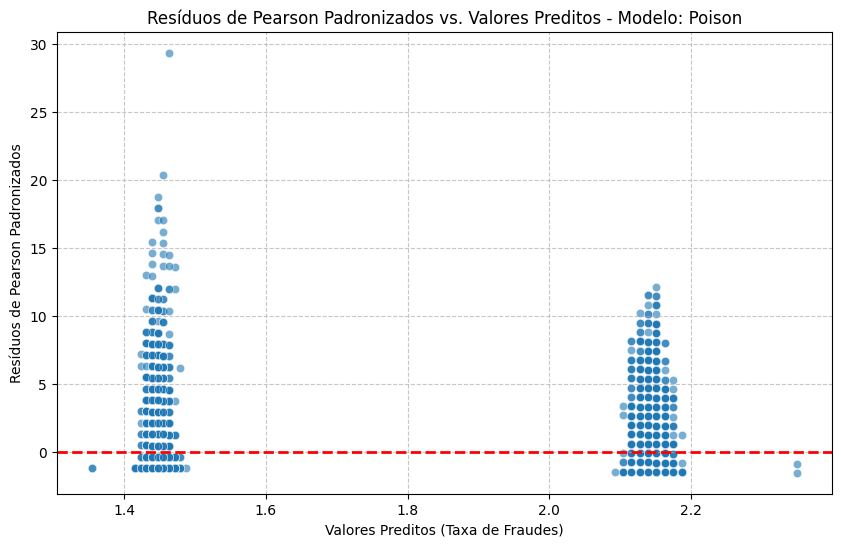

In [316]:
overdisp_plot(modelo_poison_simple, 'Poison')

In [317]:
modelo_poison_complete = smf.glm(formula=features_completa_formula, data=X, family=sm.families.Poisson()).fit()
modelo_poison_complete.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 frauds   No. Observations:                 7182
Model:                            GLM   Df Residuals:                     7122
Model Family:                 Poisson   Df Model:                           59
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -18774.
Date:                Sat, 31 May 2025   Deviance:                       29246.
Time:                        02:02:45   Pearson chi2:                 3.94e+04
No. Iterations:                     7   Pseudo R-squ. (CS):             0.4284
Covariance Type:            nonrobust                                         
===========================================================================================================
                                              coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
Intercept                                 -18.4332      7.713     -2.390      0.017     -33.551      -3.316
transactions                                0.0035      0.000     25.261      0.000       0.003       0.004
mean_amount                                -0.0016      0.006     -0.282      0.778      -0.013       0.009
std_amount                                  0.0092      0.002      4.981      0.000       0.006       0.013
skew_amount                                -0.0005      0.015     -0.033      0.974      -0.030       0.029
kurtosis_amount                            -0.0005      0.000     -1.249      0.212      -0.001       0.000
mean_current_age                            0.3676      0.027     13.847      0.000       0.316       0.420
std_current_age                            -0.6285      0.042    -15.068      0.000      -0.710      -0.547
skew_current_age                            6.3009      0.322     19.543      0.000       5.669       6.933
kurtosis_current_age                       -2.6371      0.168    -15.741      0.000      -2.965      -2.309
mean_per_capita_income                  -8.266e-05   5.58e-05     -1.481      0.139      -0.000    2.68e-05
std_per_capita_income                       0.0001   3.65e-05      3.673      0.000    6.26e-05       0.000
skew_per_capita_income                     -0.3104      0.115     -2.699      0.007      -0.536      -0.085
kurtosis_per_capita_income                  0.0124      0.007      1.711      0.087      -0.002       0.027
mean_total_debt                          6.712e-06   1.33e-05      0.505      0.614   -1.93e-05    3.28e-05
std_total_debt                            2.42e-05   1.58e-05      1.533      0.125   -6.74e-06    5.51e-05
skew_total_debt                            -0.4963      0.275     -1.803      0.071      -1.036       0.043
kurtosis_total_debt                         0.0417      0.027      1.536      0.125      -0.012       0.095
mean_credit_score                           0.0280      0.006      5.051      0.000       0.017       0.039
std_credit_score                           -0.0415      0.008     -5.115      0.000      -0.057      -0.026
skew_credit_score                           0.1621      0.243      0.668      0.504      -0.313       0.638
kurtosis_credit_score                      -0.3291      0.097     -3.409      0.001      -0.518      -0.140
mean_num_credit_cards                       2.0795      0.249      8.345      0.000       1.591       2.568
std_num_credit_cards                       -0.1368      0.387     -0.353      0.724      -0.896       0.622
skew_num_credit_cards                      -1.3037      0.275     -4.733      0.000      -1.843      -0.764
kurtosis_num_credit_cards                   0.6059      0.1

In [318]:
overdisp(modelo_poison_complete, df)

Estimating model...: 
 GLM
                        Results: Ordinary least squares
Model:                  OLS              Adj. R-squared (uncentered): 0.055     
Dependent Variable:     ystar            AIC:                         60782.6861
Date:                   2025-05-31 02:02 BIC:                         60789.5654
No. Observations:       7182             Log-Likelihood:              -30390.   
Df Model:               1                F-statistic:                 415.9     
Df Residuals:           7181             Prob (F-statistic):          6.51e-90  
R-squared (uncentered): 0.055            Scale:                       277.32    
--------------------------------------------------------------------------------------
            Coef.        Std.Err.          t          P>|t|        [0.025       0.975]
--------------------------------------------------------------------------------------
lmbda       1.9289         0.0946       20.3933       0.0000       1.7435       2.1143
--

O teste de superdispersão indica que existe indicios de superdisperção com 95% de confiança

Aplicando o processo stepwise afim de identificar se a melhor seleção de features ajuda a resolver o problema de superdispersão.

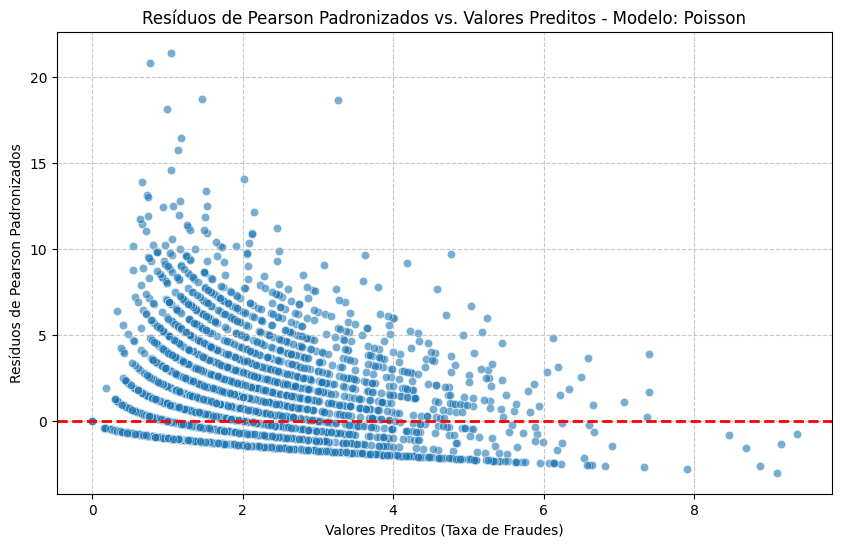

In [323]:
overdisp_plot(modelo_poison_complete, 'Poisson')

In [320]:
modelo_poisson_stepswise = stepwise(modelo_poison_complete, pvalue_limit=0.05)
modelo_poisson_stepswise.summary()

Regression type: GLM 

Estimating model...: 
 frauds ~ Q('transactions') + Q('mean_amount') + Q('std_amount') + Q('skew_amount') + Q('kurtosis_amount') + Q('mean_current_age') + Q('std_current_age') + Q('skew_current_age') + Q('kurtosis_current_age') + Q('mean_per_capita_income') + Q('std_per_capita_income') + Q('skew_per_capita_income') + Q('kurtosis_per_capita_income') + Q('mean_total_debt') + Q('std_total_debt') + Q('skew_total_debt') + Q('kurtosis_total_debt') + Q('mean_credit_score') + Q('std_credit_score') + Q('skew_credit_score') + Q('kurtosis_credit_score') + Q('mean_num_credit_cards') + Q('std_num_credit_cards') + Q('skew_num_credit_cards') + Q('kurtosis_num_credit_cards') + Q('mean_credit_limit') + Q('std_credit_limit') + Q('skew_credit_limit') + Q('kurtosis_credit_limit') + Q('use_chip_online_transaction') + Q('use_chip_swipe_transaction') + Q('use_chip_chip_transaction') + Q('gender_female') + Q('card_brand_visa') + Q('card_brand_discover') + Q('card_brand_amex') + Q('card_

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 frauds   No. Observations:                 7182
Model:                            GLM   Df Residuals:                     7140
Model Family:                 Poisson   Df Model:                           41
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -18785.
Date:                Sat, 31 May 2025   Deviance:                       29268.
Time:                        02:03:47   Pearson chi2:                 3.95e+04
No. Iterations:                     6   Pseudo R-squ. (CS):             0.4266
Covariance Type:            nonrobust                                         
================================================================================================================
                                                   coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------
Intercept                                      -13.1558      4.322     -3.044      0.002     -21.627      -4.685
Q('transactions')                                0.0035      0.000     27.413      0.000       0.003       0.004
Q('std_amount')                                  0.0083      0.001      8.328      0.000       0.006       0.010
Q('kurtosis_amount')                            -0.0005      0.000     -2.774      0.006      -0.001      -0.000
Q('mean_current_age')                            0.3575      0.024     14.642      0.000       0.310       0.405
Q('std_current_age')                            -0.6256      0.040    -15.743      0.000      -0.704      -0.548
Q('skew_current_age')                            6.1990      0.312     19.888      0.000       5.588       6.810
Q('kurtosis_current_age')                       -2.5700      0.161    -15.953      0.000      -2.886      -2.254
Q('std_per_capita_income')                    6.612e-05   2.01e-05      3.283      0.001    2.66e-05       0.000
Q('skew_per_capita_income')                     -0.0989      0.023     -4.281      0.000      -0.144      -0.054
Q('std_total_debt')                           1.705e-05   7.46e-06      2.284      0.022    2.42e-06    3.17e-05
Q('skew_total_debt')                            -0.1205      0.046     -2.624      0.009      -0.210      -0.031
Q('mean_credit_score')                           0.0273      0.005      5.011      0.000       0.017       0.038
Q('std_credit_score')                           -0.0458      0.006     -7.126      0.000      -0.058      -0.033
Q('kurtosis_credit_score')                      -0.3919      0.057     -6.828      0.000      -0.504      -0.279
Q('mean_num_credit_cards')                       2.0629      0.237      8.690      0.000       1.598       2.528
Q('skew_num_credit_cards')                      -1.3175      0.228     -5.767      0.000      -1.765      -0.870
Q('kurtosis_num_credit_cards')                   0.6278      0.111      5.651      0.000       0.410       0.846
Q('mean_credit_limit')                          -0.0002   4.67e-05     -4.860      0.000      -0.000      -0.000
Q('std_credit_limit')                           -0.0001   5.15e-05     -2.150      0.032      -0.000   -9.78e-06
Q('skew_credit_limit')                           0.3836      0.163      2.346      0.019       0.063       0.704
Q('kurtosis_credit_limit')                      -0.0260      0.012     -2.117      0.034      -0.050      -0.002
Q('use_chip_swipe_transaction')                 -8.2141      2.301     -3.570      0.000     -12.724      -3.704
Q('use_chip_chip_transaction')                  -7.2465      2.300     -3.150      0.002     -11.755      -2.738
Q('card_brand_visa')            

Aplicando a analise de superdispersão e a "plotagem" do gráfico de valores preditos X os residuos ajustados para comparar como o modelo se comporta em relação a superdispersão.

In [321]:
overdisp(modelo_poisson_stepswise, X)

Estimating model...: 
 GLM
                        Results: Ordinary least squares
Model:                  OLS              Adj. R-squared (uncentered): 0.053     
Dependent Variable:     ystar            AIC:                         61029.1596
Date:                   2025-05-31 02:03 BIC:                         61036.0389
No. Observations:       7182             Log-Likelihood:              -30514.   
Df Model:               1                F-statistic:                 402.4     
Df Residuals:           7181             Prob (F-statistic):          3.95e-87  
R-squared (uncentered): 0.053            Scale:                       287.01    
--------------------------------------------------------------------------------------
            Coef.        Std.Err.          t          P>|t|        [0.025       0.975]
--------------------------------------------------------------------------------------
lmbda       1.9317         0.0963       20.0593       0.0000       1.7429       2.1204
--

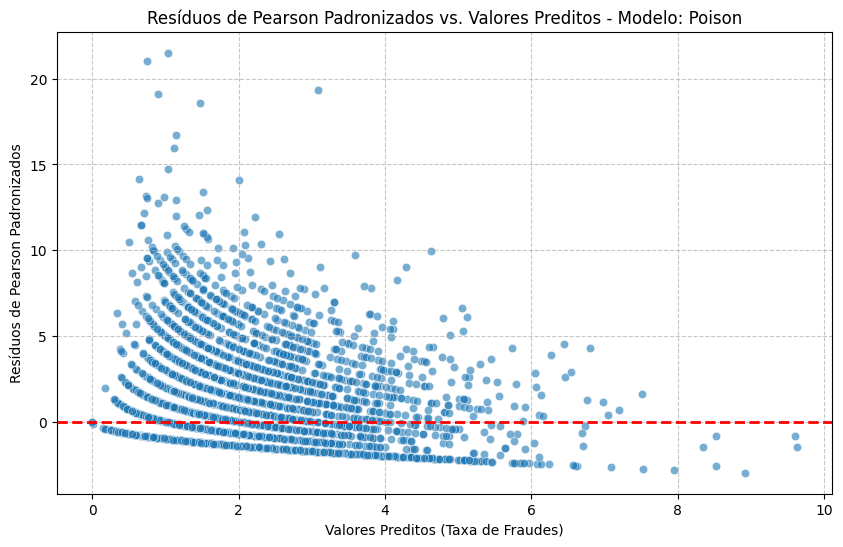

In [322]:
overdisp_plot(modelo_poisson_stepswise, 'Poison')

TODO: Rever

O gráfico evidencia uma caracteristica marcante no problema de superdispersão que é o padrão de "cone" extremamente acentuado, que se abre drasticamente quando os valores preditos se aproximam de zero. Caso o modelo fosse bem ajustado, eperariamos que os resudios estivessem distribuidos em torno de zero, sem padrões visiveis e com uma variancia mais ou menos constante.

In [324]:
summary_col([modelo_poison_simple, modelo_poison_complete, modelo_poisson_stepswise],
            model_names=["Poisson Simples", "Poisson Completo", "Poisson StepWise"],
            stars=True,
            info_dict = {
                'N':lambda x: "{0:d}".format(int(x.nobs)),
                'Log-lik':lambda x: "{:.2f}".format(x.llf)
        })

<class 'statsmodels.iolib.summary2.Summary'>
"""

==============================================================================================
                                             Poisson Simples Poisson Completo Poisson StepWise
----------------------------------------------------------------------------------------------
Intercept                                    0.8542***       -18.4332**       -13.1558***     
                                             (0.0145)        (7.7132)         (4.3221)        
use_chip_swipe_transaction                   -0.5508***      -7.2322***                       
                                             (0.0251)        (2.3602)                         
transactions                                                 0.0035***                        
                                                             (0.0001)                         
mean_amount                                                  -0.0016                          
                                                             (0.0056)                         
std_amount                                                   0.0092***                        
                                                             (0.0018)                         
skew_amount                                                  -0.0005                          
                                                             (0.0152)                         
kurtosis_amount                                              -0.0005                          
                                                             (0.0004)                         
mean_current_age                                             0.3676***                        
                                                             (0.0265)                         
std_current_age                                              -0.6285***                       
                                                             (0.0417)                         
skew_current_age                                             6.3009***                        
                                                             (0.3224)                         
kurtosis_current_age                                         -2.6371***                       
                                                             (0.1675)                         
mean_per_capita_income                                       -0.0001                          
                                                             (0.0001)                         
std_per_capita_income                                        0.0001***                        
                                                             (0.0000)                         
skew_per_capita_income                                       -0.3104***                       
                                                             (0.1150)                         
kurtosis_per_capita_income                                   0.0124*                          
                                                             (0.0072)                         
mean_total_debt                                              0.0000                           
                                                             (0.0000)                         
std_total_debt                                               0.0000                           
                                                             (0.0000)                         
skew_total_debt                                              -0.4963*                         
                                                             (0.2753)                         
kurtosis_total_debt                                          0.0417                           
                                                             (0.0271)                         
mean_credit_score                                      

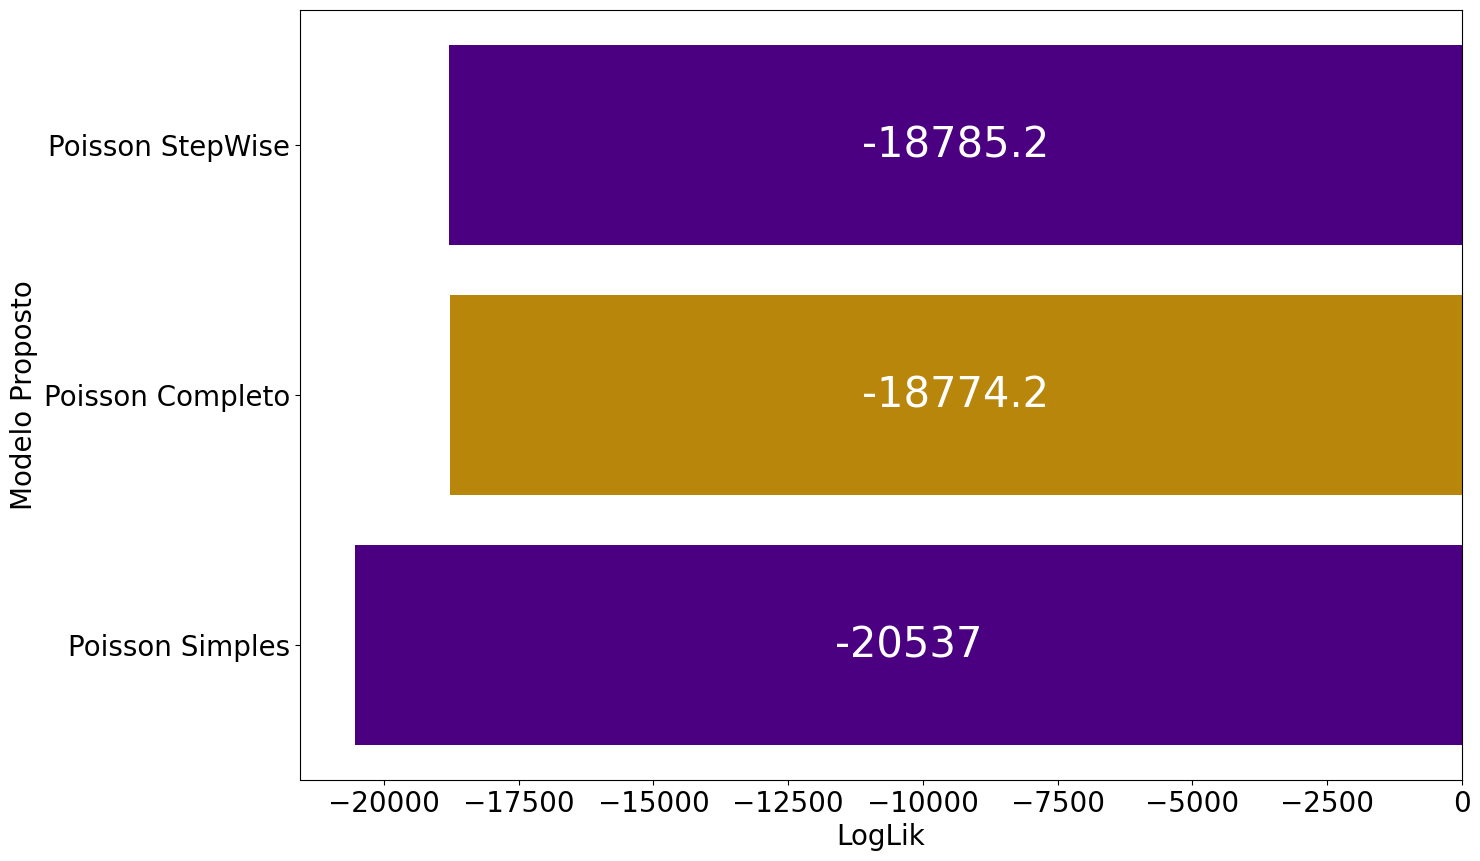

In [325]:
compare_models({
    'modelo':['Poisson Simples', 'Poisson Completo', 'Poisson StepWise'],
    'loglik':[modelo_poison_simple.llf, modelo_poison_complete.llf, modelo_poisson_stepswise.llf]
})

### Binomial Negative (Poisson-Gama)

In [326]:
result_tests = {}
for column in X.drop(columns=['frauds']).columns[1:]:
  model_test = smf.glm(formula=f'frauds ~ {column}', data=X, family=sm.families.NegativeBinomial()).fit(disp=True)
  result_tests[column] = model_test.pseudo_rsquared()
column_max = list(result_tests.keys())[np.argmax(list(result_tests.values()))]
column_max

'online_sales_no'

In [327]:
modelo_binomialneg_simples = smf.glm(formula=f'frauds ~ {column_max}', data=X, family=sm.families.NegativeBinomial()).fit()
modelo_binomialneg_simples.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 frauds   No. Observations:                 7182
Model:                            GLM   Df Residuals:                     7180
Model Family:        NegativeBinomial   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -12969.
Date:                Sat, 31 May 2025   Deviance:                       13196.
Time:                        02:04:49   Pearson chi2:                 1.58e+04
No. Iterations:                    10   Pseudo R-squ. (CS):            0.02728
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          14.7640      0.902     16.372      0.000      12.997      16.531
online_sales_no   -16.1932      1.029    -15.735      0.000     -18.210     -14.176
===================================================================================
"""

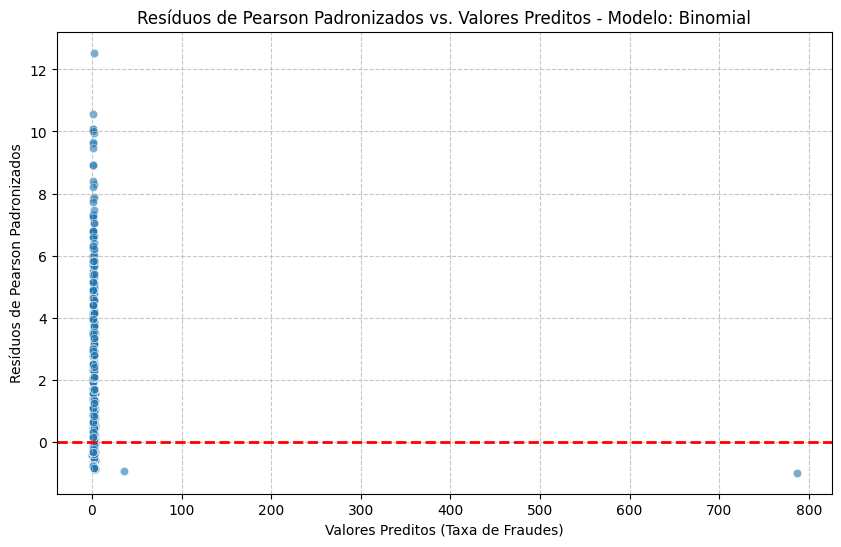

In [328]:
overdisp_plot(modelo_binomialneg_simples, 'Binomial')

In [329]:
modelo_binomialneg_completo = smf.glm(formula=features_completa_formula, data=X, family=sm.families.NegativeBinomial()).fit()
modelo_binomialneg_completo.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 frauds   No. Observations:                 7182
Model:                            GLM   Df Residuals:                     7122
Model Family:        NegativeBinomial   Df Model:                           59
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -12308.
Date:                Sat, 31 May 2025   Deviance:                       11874.
Time:                        02:05:52   Pearson chi2:                 1.56e+04
No. Iterations:                    12   Pseudo R-squ. (CS):             0.1908
Covariance Type:            nonrobust                                         
===========================================================================================================
                                              coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
Intercept                                 -39.3474     13.806     -2.850      0.004     -66.406     -12.289
transactions                                0.0035      0.000     14.915      0.000       0.003       0.004
mean_amount                                 0.0007      0.010      0.066      0.947      -0.019       0.020
std_amount                                  0.0097      0.003      2.861      0.004       0.003       0.016
skew_amount                                -0.0408      0.029     -1.416      0.157      -0.097       0.016
kurtosis_amount                             0.0009      0.001      1.075      0.282      -0.001       0.003
mean_current_age                            0.3951      0.046      8.608      0.000       0.305       0.485
std_current_age                            -0.7245      0.072    -10.078      0.000      -0.865      -0.584
skew_current_age                            7.2453      0.557     13.005      0.000       6.153       8.337
kurtosis_current_age                       -2.9932      0.290    -10.318      0.000      -3.562      -2.425
mean_per_capita_income                     -0.0001   9.68e-05     -1.460      0.144      -0.000    4.84e-05
std_per_capita_income                       0.0002   6.34e-05      2.907      0.004       6e-05       0.000
skew_per_capita_income                     -0.4100      0.197     -2.080      0.038      -0.796      -0.024
kurtosis_per_capita_income                  0.0171      0.012      1.382      0.167      -0.007       0.041
mean_total_debt                         -1.057e-06   2.28e-05     -0.046      0.963   -4.58e-05    4.37e-05
std_total_debt                           5.381e-05   2.71e-05      1.983      0.047    6.37e-07       0.000
skew_total_debt                            -1.0922      0.473     -2.308      0.021      -2.020      -0.165
kurtosis_total_debt                         0.0949      0.047      2.036      0.042       0.004       0.186
mean_credit_score                           0.0405      0.010      4.242      0.000       0.022       0.059
std_credit_score                           -0.0321      0.014     -2.294      0.022      -0.060      -0.005
skew_credit_score                           0.1865      0.418      0.446      0.655      -0.633       1.006
kurtosis_credit_score                      -0.3324      0.167     -1.995      0.046      -0.659      -0.006
mean_num_credit_cards                       2.0883      0.430      4.857      0.000       1.246       2.931
std_num_credit_cards                       -0.1133      0.667     -0.170      0.865      -1.421       1.194
skew_num_credit_cards                      -1.3150      0.474     -2.773      0.006      -2.244      -0.386
kurtosis_num_credit_cards                   0.6013      0.2

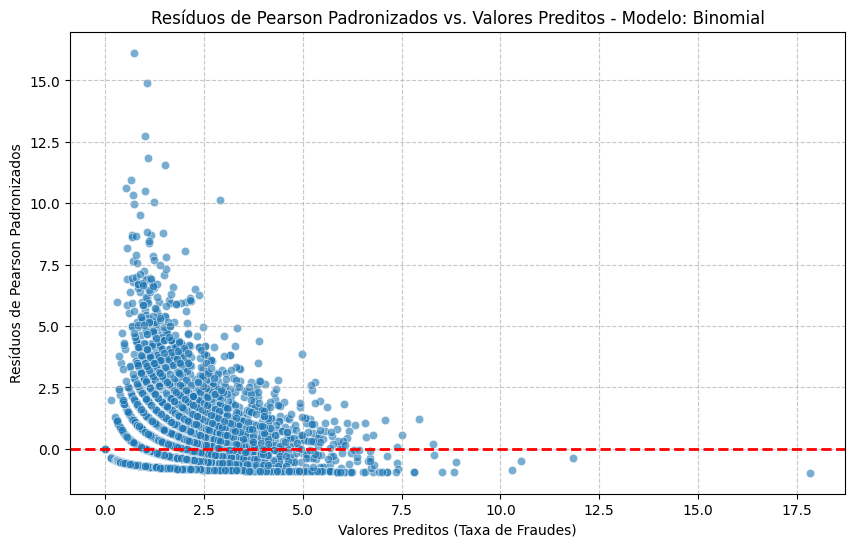

In [330]:
overdisp_plot(modelo_binomialneg_completo, 'Binomial')

In [331]:
modelo_binomialneg_stepwise = stepwise(modelo_binomialneg_completo, pvalue_limit=0.05)
modelo_binomialneg_stepwise.summary()

Regression type: GLM 

Estimating model...: 
 frauds ~ Q('transactions') + Q('mean_amount') + Q('std_amount') + Q('skew_amount') + Q('kurtosis_amount') + Q('mean_current_age') + Q('std_current_age') + Q('skew_current_age') + Q('kurtosis_current_age') + Q('mean_per_capita_income') + Q('std_per_capita_income') + Q('skew_per_capita_income') + Q('kurtosis_per_capita_income') + Q('mean_total_debt') + Q('std_total_debt') + Q('skew_total_debt') + Q('kurtosis_total_debt') + Q('mean_credit_score') + Q('std_credit_score') + Q('skew_credit_score') + Q('kurtosis_credit_score') + Q('mean_num_credit_cards') + Q('std_num_credit_cards') + Q('skew_num_credit_cards') + Q('kurtosis_num_credit_cards') + Q('mean_credit_limit') + Q('std_credit_limit') + Q('skew_credit_limit') + Q('kurtosis_credit_limit') + Q('use_chip_online_transaction') + Q('use_chip_swipe_transaction') + Q('use_chip_chip_transaction') + Q('gender_female') + Q('card_brand_visa') + Q('card_brand_discover') + Q('card_brand_amex') + Q('card_

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 frauds   No. Observations:                 7182
Model:                            GLM   Df Residuals:                     7148
Model Family:        NegativeBinomial   Df Model:                           33
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -12325.
Date:                Sat, 31 May 2025   Deviance:                       11906.
Time:                        02:07:02   Pearson chi2:                 1.57e+04
No. Iterations:                    10   Pseudo R-squ. (CS):             0.1871
Covariance Type:            nonrobust                                         
================================================================================================================
                                                   coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------
Intercept                                      -59.2715      7.308     -8.111      0.000     -73.594     -44.949
Q('transactions')                                0.0035      0.000     16.880      0.000       0.003       0.004
Q('std_amount')                                  0.0063      0.001      5.015      0.000       0.004       0.009
Q('mean_current_age')                            0.3964      0.042      9.428      0.000       0.314       0.479
Q('std_current_age')                            -0.7112      0.068    -10.411      0.000      -0.845      -0.577
Q('skew_current_age')                            7.1283      0.534     13.344      0.000       6.081       8.175
Q('kurtosis_current_age')                       -2.9500      0.278    -10.608      0.000      -3.495      -2.405
Q('std_per_capita_income')                    9.135e-05   3.19e-05      2.861      0.004    2.88e-05       0.000
Q('skew_per_capita_income')                     -0.1023      0.038     -2.663      0.008      -0.178      -0.027
Q('std_total_debt')                           4.536e-05    1.6e-05      2.832      0.005     1.4e-05    7.68e-05
Q('skew_total_debt')                            -0.9263      0.376     -2.464      0.014      -1.663      -0.190
Q('kurtosis_total_debt')                         0.0815      0.040      2.057      0.040       0.004       0.159
Q('mean_credit_score')                           0.0437      0.009      4.649      0.000       0.025       0.062
Q('std_credit_score')                           -0.0356      0.011     -3.205      0.001      -0.057      -0.014
Q('kurtosis_credit_score')                      -0.3868      0.099     -3.913      0.000      -0.581      -0.193
Q('mean_num_credit_cards')                       2.1803      0.409      5.327      0.000       1.378       2.982
Q('skew_num_credit_cards')                      -1.1849      0.394     -3.010      0.003      -1.956      -0.413
Q('kurtosis_num_credit_cards')                   0.5427      0.192      2.824      0.005       0.166       0.919
Q('mean_credit_limit')                          -0.0003   5.05e-05     -6.733      0.000      -0.000      -0.000
Q('use_chip_online_transaction')                29.9268      1.608     18.606      0.000      26.774      33.079
Q('use_chip_swipe_transaction')                 -1.1742      0.074    -15.920      0.000      -1.319      -1.030
Q('card_brand_visa')                            -3.5979      1.069     -3.365      0.001      -5.694      -1.502
Q('category_retail_specialty')                  21.7895      2.389      9.120      0.000      17.106      26.472
Q('category_transportation_logistics')          -4.6874      1.563     -2.999      0.003      -7.751      -1.624
Q('category_professional_busines

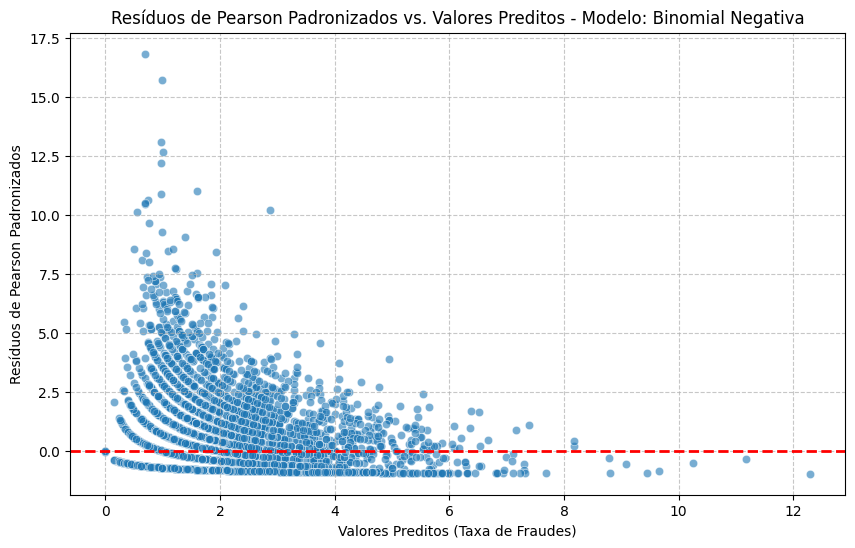

In [332]:
overdisp_plot(modelo_binomialneg_stepwise, 'Binomial Negativa')

In [333]:
lrtest([modelo_binomialneg_completo, modelo_binomialneg_stepwise])

Likelihood Ratio Test:
-2.(LL0-LLm): -32.37
p-value: 1.000

==================Result======================== 

H0: Models with log-likelihoods that are not statistically different at 95% confidence level


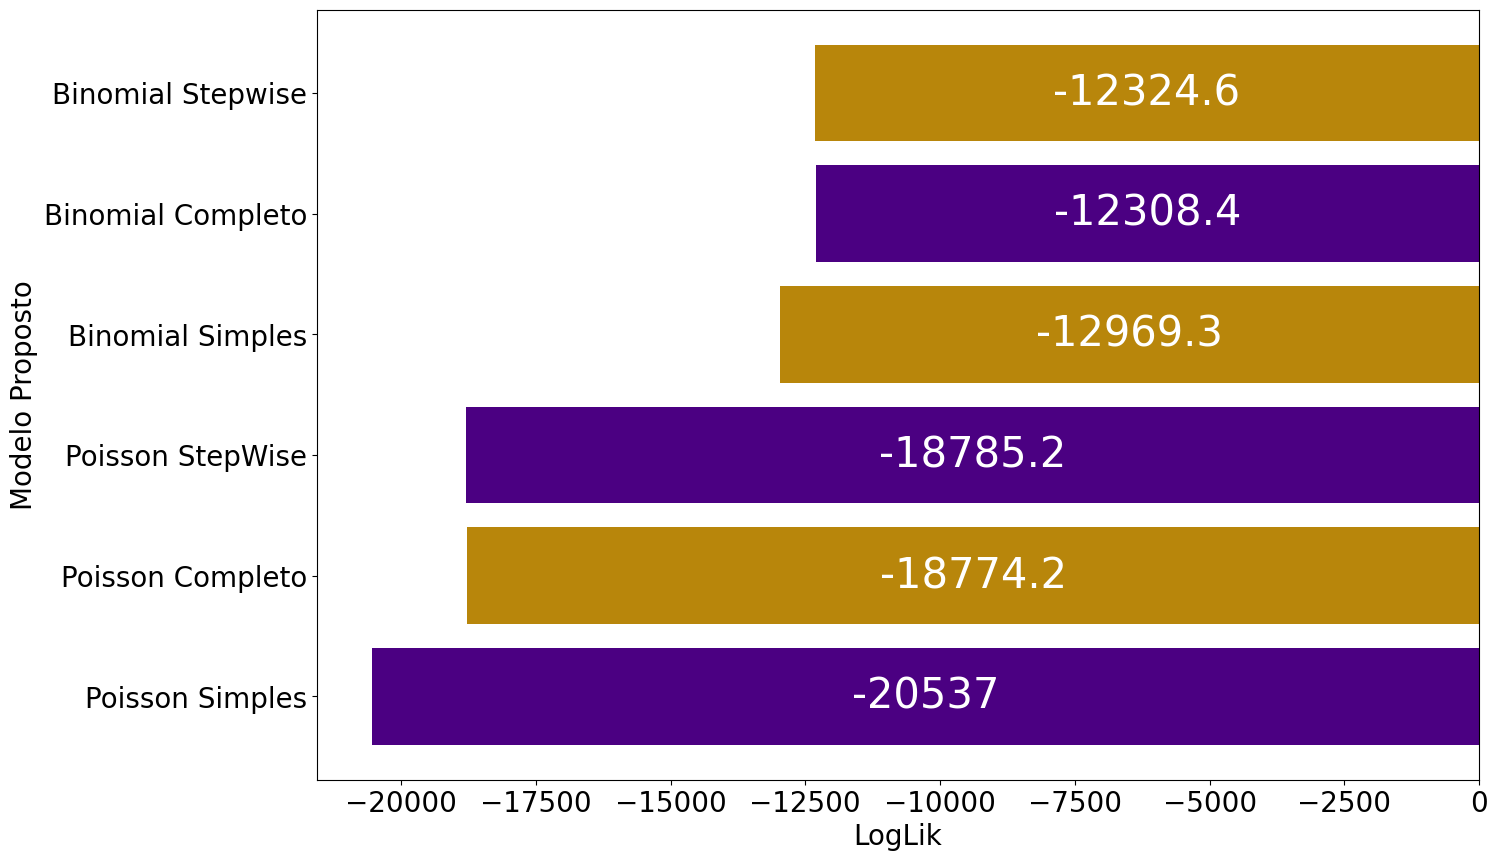

In [334]:
compare_models({
    'modelo':['Poisson Simples', 'Poisson Completo', 'Poisson StepWise', 'Binomial Simples', 'Binomial Completo', 'Binomial Stepwise'],
    'loglik':[modelo_poison_simple.llf, modelo_poison_complete.llf, modelo_poisson_stepswise.llf, modelo_binomialneg_simples.llf, modelo_binomialneg_completo.llf, modelo_binomialneg_stepwise.llf]
})

### Zero Inflated Poison

In [335]:
X_log = X.drop(columns=['frauds']).copy()
for column in X_log.columns:
  X_log[column] = np.log(X_log[column] + 1)
X_log.head()

transactions  mean_amount  std_amount  skew_amount  kurtosis_amount  \
0      6.852243     3.609470    4.076729     2.265115         4.998203   
1      7.128496     3.985109    4.330506     2.101994         4.459709   
2      6.673298     4.007814    4.627581     2.153499         4.352232   
3      7.003065     3.976469    4.160520     1.832507         3.909527   
4      6.867974     3.771639    4.127360     1.758877         3.675592   

   mean_current_age  std_current_age  skew_current_age  kurtosis_current_age  \
0          4.033294         2.775501          0.460938             -0.176129   
1          4.042953         2.816322          0.444922             -0.552868   
2          4.032200         2.785213          0.452225             -0.352087   
3          4.028369         2.779754          0.506083             -0.196753   
4          4.013545         2.783278          0.493329             -0.213773   

   mean_per_capita_income  ...  category_retail_home_garden  \
0               10.079570  ...                     0.009950   
1               10.102210  ...                     0.009950   
2               10.086920  ...                     0.039221   
3               10.070067  ...                     0.029559   
4               10.073814  ...                     0.029559   

   category_retail_general_department  category_technology_telecommunications  \
0                            0.048790                                0.019803   
1                            0.048790                                0.019803   
2                            0.122218                                0.029559   
3                            0.122218                                0.029559   
4                            0.086178                                0.029559   

   category_travel_hospitality  category_arts_entertainment_recreation  \
0                          0.0                                0.019803   
1                          0.0                                0.048790   
2                          0.0                                0.009950   
3                          0.0                                0.048790   
4                          0.0                                0.009950   

   category_health_medical  category_financial_insurance  \
0                 0.039221                      0.048790   
1                 0.029559                      0.048790   
2                 0.058269                      0.048790   
3                 0.058269                      0.058269   
4                 0.076961                      0.039221   

   category_retail_clothing_accessories  category_food_beverage  \
0                               0.00000                0.392042   
1                               0.00995                0.385262   
2                               0.00995                0.300105   
3                               0.00000                0.277632   
4                               0.00995                0.336472   

   category_personal_services  
0                     0.00000  
1                     0.00000  
2                     0.00995  
3                     0.00995  
4                     0.00995  

[5 rows x 59 columns]

In [336]:
exclude_columns = X_log.isna().sum().reset_index().rename(columns={0:'missing'}).query('missing > 0')['index'].to_list()
X_droped = X.drop(columns=exclude_columns)

In [337]:
standard_scaler = StandardScaler()
X_scaler = standard_scaler.fit_transform(X_droped)

X_scaler = pd.DataFrame(X_scaler, columns=X_droped.columns).drop(columns='frauds')
X_scaler.head()

transactions  mean_amount  std_amount  skew_amount  mean_current_age  \
0     -1.628775    -0.822045   -0.980488     0.915786          2.075043   
1      0.460632     0.129359    0.181179     0.346136          2.916453   
2     -2.704716     0.199130    1.974022     0.516070          1.980199   
3     -0.559776     0.103221   -0.629027    -0.413366          1.649108   
4     -1.524652    -0.454651   -0.771648    -0.587674          0.379614   

   std_current_age  skew_current_age  mean_per_capita_income  \
0        -1.709146          0.782614               -0.301128   
1         0.001346          0.313673                1.127281   
2        -1.308492          0.526574                0.159088   
3        -1.534171          2.145621               -0.891112   
4        -1.388630          1.754300               -0.659162   

   std_per_capita_income  skew_per_capita_income  ...  \
0              -0.980321               -0.450855  ...   
1               1.689300                0.969247  ...   
2               0.507710                0.908403  ...   
3               1.980585                1.340768  ...   
4              -1.479377               -1.895101  ...   

   category_retail_home_garden  category_retail_general_department  \
0                    -1.826227                           -2.869381   
1                    -1.826227                           -2.869381   
2                     1.408023                            1.375184   
3                     0.329940                            1.375184   
4                     0.329940                           -0.747098   

   category_technology_telecommunications  category_travel_hospitality  \
0                               -1.195256                    -0.194574   
1                               -1.195256                    -0.194574   
2                                0.186861                    -0.194574   
3                                0.186861                    -0.194574   
4                                0.186861                    -0.194574   

   category_arts_entertainment_recreation  category_health_medical  \
0                                0.190061                -2.920140   
1                                2.053993                -3.886567   
2                               -0.431249                -0.987285   
3                                2.053993                -0.987285   
4                               -0.431249                 0.945570   

   category_financial_insurance  category_retail_clothing_accessories  \
0                     -0.088895                             -2.187367   
1                     -0.088895                              0.355885   
2                     -0.088895                              0.355885   
3                      1.019515                             -2.187367   
4                     -1.197305                              0.355885   

   category_food_beverage  category_personal_services  
0                3.075343                   -2.312583  
1                2.803736                   -2.312583  
2               -0.455553                   -0.182682  
3               -1.270375                   -0.182682  
4                0.902484                   -0.182682  

[5 rows x 52 columns]

In [350]:
result_tests = {}
for column in X_scaler.columns:
  X1 = X_scaler[column]
  X1 = sm.add_constant(X1)

  modelo_zip_test = sm.ZeroInflatedPoisson(y, X1, exog_infl=X1, inflation='probit').fit(disp=False, cov_type='HC0')# sm.ZeroInflatedPoisson(y, X1, exog_infl=X1, inflation='probit').fit(cov_type='HC0', disp=False)
  result_tests[column] = modelo_zip_test.prsquared

column_max = list(result_tests.keys())[np.argmax(list(result_tests.values()))]
column_max

'transactions'

In [351]:
X1 = X_scaler[column_max].copy()
X1 = sm.add_constant(X1)

In [352]:
modelo_zip_simples = sm.ZeroInflatedPoisson(y, X1, exog_infl=X1, inflation='probit').fit(disp=False, cov_type='HC0')
modelo_zip_simples.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     ZeroInflatedPoisson Regression Results                    
===============================================================================
Dep. Variable:                  frauds   No. Observations:                 7182
Model:             ZeroInflatedPoisson   Df Residuals:                     7180
Method:                            MLE   Df Model:                            1
Date:                 Sat, 31 May 2025   Pseudo R-squ.:                 0.01284
Time:                         02:15:20   Log-Likelihood:                -12396.
converged:                        True   LL-Null:                       -12558.
Covariance Type:                   HC0   LLR p-value:                 4.379e-72
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
inflate_const            0.3338      0.015     21.839      0.000       0.304       0.364
inflate_transactions    -0.0730      0.016     -4.708      0.000      -0.103      -0.043
const                    1.5510      0.018     87.587      0.000       1.516       1.586
transactions             0.1717      0.021      8.251      0.000       0.131       0.213
========================================================================================
"""

In [353]:
vuong_test(modelo_poison_simple, modelo_zip_simples)

Optimization terminated successfully.
         Current function value: 2.859509
         Iterations 5
Vuong Non-Nested Hypothesis Test-Statistic (Raw):
Vuong z-statistic: -40.064
p-value: 0.000

==================Result======================== 

H1: Indicates inflation of zeros at 95% confidence level


In [354]:
X1 = X_scaler.copy(deep=True)
X1 = sm.add_constant(X1)

In [355]:
modelo_zip_complete = sm.ZeroInflatedPoisson(y, X1, exog_infl=X1, inflation='probit').fit(disp=False, cov_type='HC0')
modelo_zip_complete.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     ZeroInflatedPoisson Regression Results                    
===============================================================================
Dep. Variable:                  frauds   No. Observations:                 7182
Model:             ZeroInflatedPoisson   Df Residuals:                     7129
Method:                            MLE   Df Model:                           52
Date:                 Sat, 31 May 2025   Pseudo R-squ.:                 0.05662
Time:                         02:16:45   Log-Likelihood:                -11846.
converged:                       False   LL-Null:                       -12558.
Covariance Type:                   HC0   LLR p-value:                2.142e-263
===================================================================================================================
                                                      coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------
inflate_const                                       0.3558      0.030     11.954      0.000       0.297       0.414
inflate_transactions                               -0.1741      0.034     -5.088      0.000      -0.241      -0.107
inflate_mean_amount                                -0.0467      0.181     -0.257      0.797      -0.402       0.309
inflate_std_amount                                 -0.0561      0.049     -1.135      0.256      -0.153       0.041
inflate_skew_amount                                 0.0361      0.032      1.134      0.257      -0.026       0.098
inflate_mean_current_age                           -0.2024      0.030     -6.689      0.000      -0.262      -0.143
inflate_std_current_age                             0.1193      0.025      4.681      0.000       0.069       0.169
inflate_skew_current_age                           -0.1173      0.020     -5.895      0.000      -0.156      -0.078
inflate_mean_per_capita_income                     -0.0266      0.037     -0.723      0.470      -0.099       0.045
inflate_std_per_capita_income                      -0.0706      0.048     -1.466      0.143      -0.165       0.024
inflate_skew_per_capita_income                      0.0577      0.035      1.643      0.100      -0.011       0.127
inflate_mean_total_debt                             0.0216      0.039      0.555      0.579      -0.055       0.098
inflate_std_total_debt                              0.0134      0.041      0.326      0.744      -0.067       0.094
inflate_skew_total_debt                            -0.0036      0.032     -0.114      0.910      -0.066       0.059
inflate_mean_credit_score                          -0.0375      0.019     -1.928      0.054      -0.076       0.001
inflate_std_credit_score                            0.0129      0.020      0.658      0.510      -0.025       0.051
inflate_skew_credit_score                           0.0025      0.018      0.146      0.884      -0.032       0.037
inflate_mean_num_credit_cards                      -0.0984      0.024     -4.128      0.000      -0.145      -0.052
inflate_std_num_credit_cards                        0.0429      0.020      2.185      0.029       0.004       0.081
inflate_skew_num_credit_cards                      -0.0064      0.022     -0.298      0.766      -0.049       0.036
inflate_mean_credit_limit                           0.1865      0.039      4.770      0.000       0.110       0.263
inflate_std_credit_limit                           -0.0627      0.047     -1.333      0.183      -0.155       0.030
inflate_skew_credit_limit                           0.0325      0.034      0.953      0.341      -0.034       0.099
inflate_use_chip_online_transaction                -0.0752      0.144     -0.523      0.601      -0.357       0.207
inflate_use_chip_swipe_transaction                  0.2641      1.621      0.163      0.871      -2.

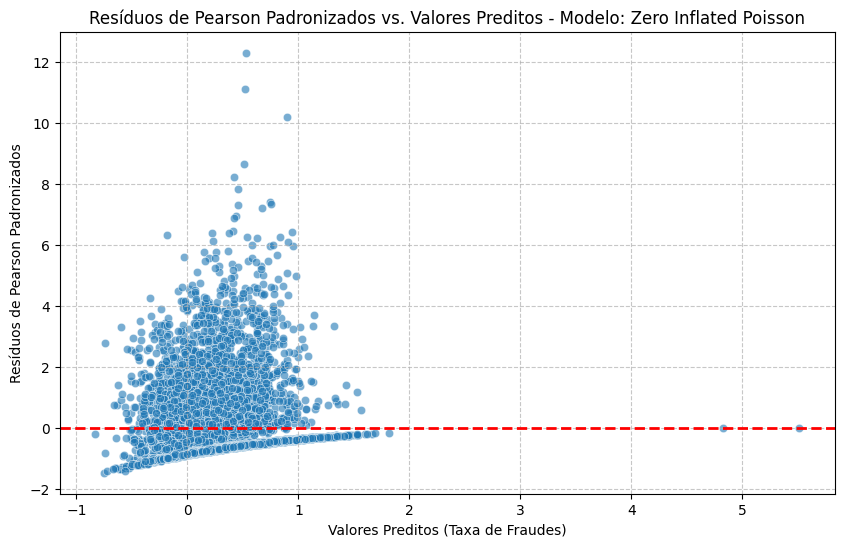

In [356]:
overdisp_plot(modelo_zip_complete, 'Zero Inflated Poisson')

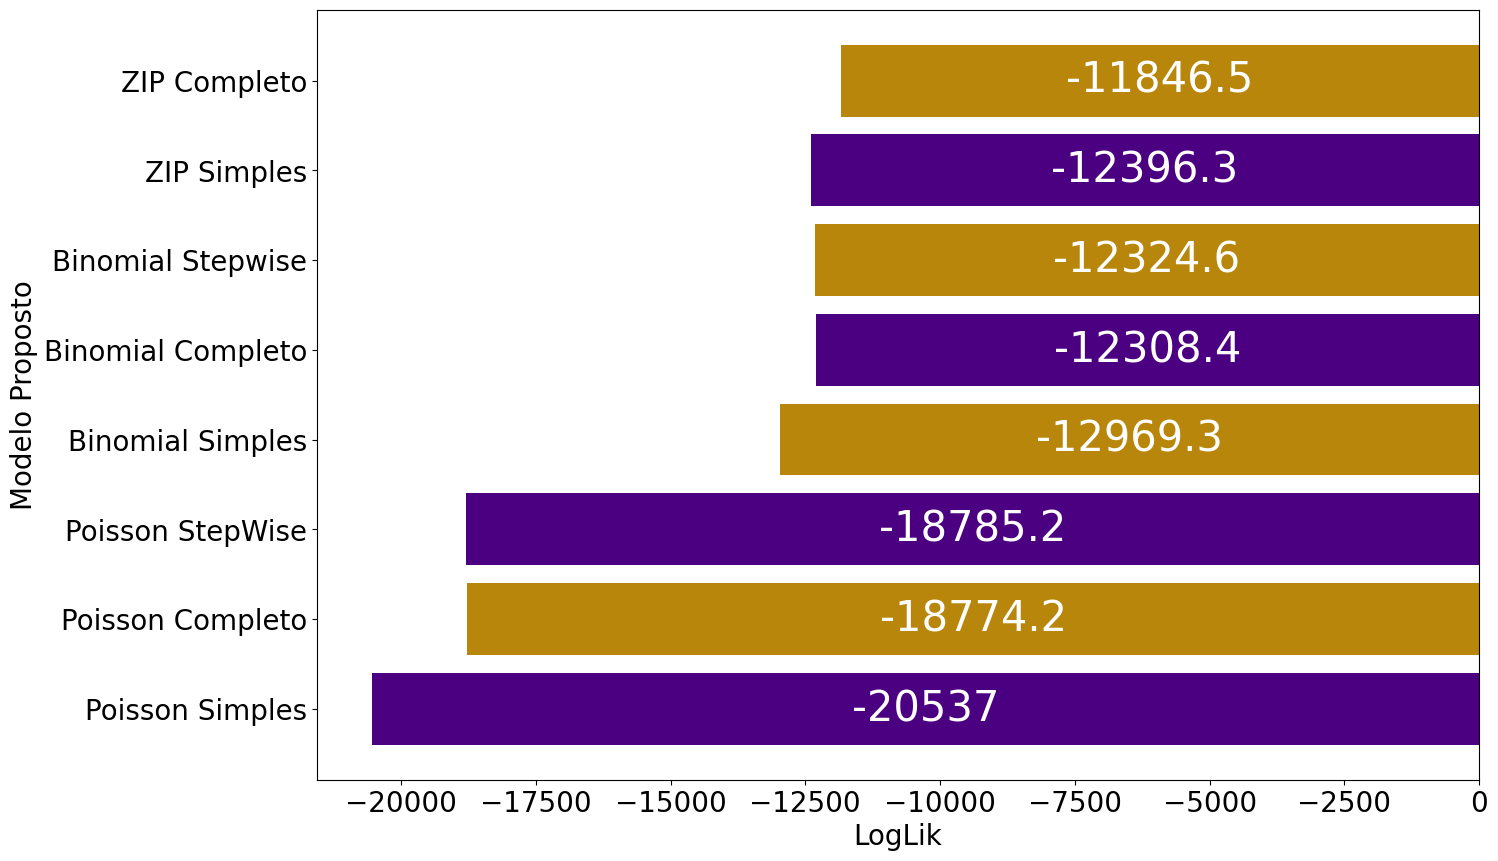

In [359]:
compare_models({
    'modelo':[
        'Poisson Simples',
        'Poisson Completo',
        'Poisson StepWise',
        'Binomial Simples',
        'Binomial Completo',
        'Binomial Stepwise',
        'ZIP Simples',
        'ZIP Completo'
    ],
    'loglik':[
        modelo_poison_simple.llf,
        modelo_poison_complete.llf,
        modelo_poisson_stepswise.llf,
        modelo_binomialneg_simples.llf,
        modelo_binomialneg_completo.llf,
        modelo_binomialneg_stepwise.llf,
        modelo_zip_simples.llf,
        modelo_zip_complete.llf
      ]
})

In [360]:
df_features_zip_complete = modelo_zip_complete.pvalues.where(lambda x: x < 0.05).dropna().reset_index().rename(columns={'index':'Features', 0:'P-Value'})
feature_exog = list(filter(lambda x: x!='const', df_features_zip_complete.query('~Features.str.contains("inflate_")')['Features'].apply(lambda x: str(x).replace('inflate_','')).to_list()))
print('Exogenas')
print(feature_exog)
feature_exog_inflate = list(filter(lambda x: x!='const', df_features_zip_complete.query('Features.str.contains("inflate_")')['Features'].apply(lambda x: str(x).replace('inflate_','')).to_list()))
print('Exogenas Inflado')
print(feature_exog_inflate)

Exogenas
['transactions', 'skew_credit_score', 'mean_num_credit_cards', 'std_credit_limit', 'category_retail_specialty', 'category_government_utilities', 'category_retail_home_garden', 'category_retail_general_department']
Exogenas Inflado
['transactions', 'mean_current_age', 'std_current_age', 'skew_current_age', 'mean_num_credit_cards', 'std_num_credit_cards', 'mean_credit_limit', 'category_retail_specialty', 'category_professional_business_services', 'category_retail_general_department', 'category_travel_hospitality', 'category_arts_entertainment_recreation', 'category_food_beverage']


In [362]:
X1 = X_scaler[feature_exog].copy()
X1 = sm.add_constant(X1)

X2 = X_scaler[feature_exog_inflate].copy()
X2 = sm.add_constant(X2)

modelo_zip_complete_filter = sm.ZeroInflatedPoisson(y, X1, exog_infl=X2, inflation='probit').fit(disp=False, cov_type='HC0')
modelo_zip_complete_filter.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     ZeroInflatedPoisson Regression Results                    
===============================================================================
Dep. Variable:                  frauds   No. Observations:                 7182
Model:             ZeroInflatedPoisson   Df Residuals:                     7173
Method:                            MLE   Df Model:                            8
Date:                 Sat, 31 May 2025   Pseudo R-squ.:                 0.02725
Time:                         02:18:32   Log-Likelihood:                -12215.
converged:                        True   LL-Null:                       -12558.
Covariance Type:                   HC0   LLR p-value:                1.599e-142
===================================================================================================================
                                                      coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------
inflate_const                                       0.3414      0.016     21.971      0.000       0.311       0.372
inflate_transactions                               -0.1686      0.025     -6.811      0.000      -0.217      -0.120
inflate_mean_current_age                            0.0109      0.022      0.492      0.623      -0.033       0.054
inflate_std_current_age                            -0.0089      0.021     -0.422      0.673      -0.050       0.032
inflate_skew_current_age                            0.0170      0.017      0.988      0.323      -0.017       0.051
inflate_mean_num_credit_cards                      -0.1239      0.022     -5.623      0.000      -0.167      -0.081
inflate_std_num_credit_cards                        0.0205      0.018      1.145      0.252      -0.015       0.056
inflate_mean_credit_limit                           0.0877      0.019      4.555      0.000       0.050       0.125
inflate_category_retail_specialty                  -0.0436      0.026     -1.675      0.094      -0.095       0.007
inflate_category_professional_business_services     0.0290      0.016      1.863      0.062      -0.002       0.059
inflate_category_retail_general_department         -0.0677      0.030     -2.245      0.025      -0.127      -0.009
inflate_category_travel_hospitality                 0.0240      0.044      0.551      0.582      -0.061       0.109
inflate_category_arts_entertainment_recreation      0.1717      0.023      7.438      0.000       0.126       0.217
inflate_category_food_beverage                     -0.0644      0.031     -2.071      0.038      -0.125      -0.003
const                                               1.5276      0.018     85.370      0.000       1.493       1.563
transactions                                        0.2492      0.029      8.731      0.000       0.193       0.305
skew_credit_score                                   0.0680      0.017      4.043      0.000       0.035       0.101
mean_num_credit_cards                               0.0664      0.020      3.293      0.001       0.027       0.106
std_credit_limit                                   -0.0155      0.017     -0.914      0.361      -0.049       0.018
category_retail_specialty                           0.1079      0.026      4.177      0.000       0.057       0.159
category_government_utilities                      -0.0427      0.017     -2.470      0.014      -0.077      -0.009
category_retail_home_garden                         0.0323      0.022      1.455      0.146      -0.011       0.076
category_retail_general_department                  0.0624      0.022      2.793      0.005       0.019       0.106
===================================================================================================================
"""

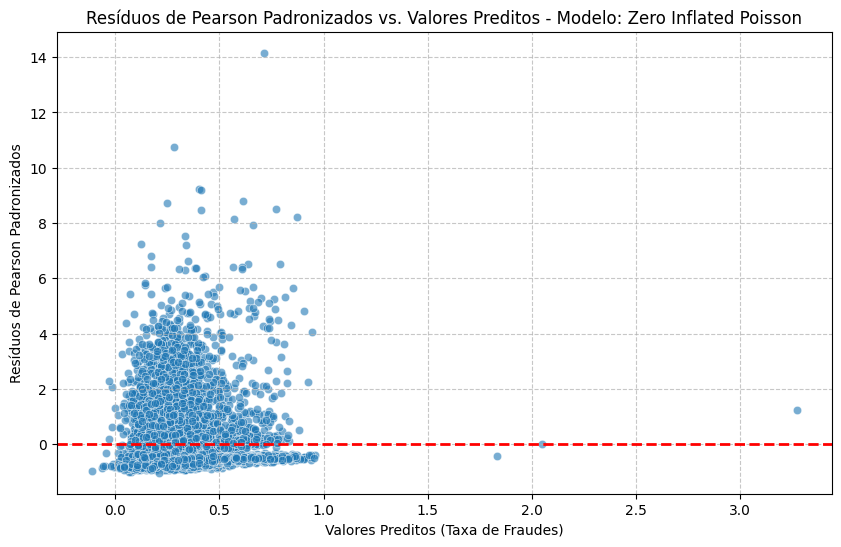

In [363]:
overdisp_plot(modelo_zip_complete_filter, 'Zero Inflated Poisson')

In [364]:
step_wise = StepwiseZeroInflated(alpha=0.05, model_type='ZIP', verbose=True, model_params=dict(inflation='probit'), fit_params=dict(cov_type='HC0', disp=False))
step_wise.fit_transform(X_scaler, y)

INICIANDO PROCESSO STEPWISE
Modelo: ZIP
Critério de seleção: AIC
Features disponíveis: 52
Dataset: 7182 observações, 4556 zeros (63.4%)
--------------------------------------------------------------------------------
Modelo baseline ajustado:
  - Observações: 7182
  - Zeros: 4556 (63.4%)
  - AIC baseline: 25119.02
  - Convergiu: True
AIC inicial (modelo nulo): 25119.02
--------------------------------------------------------------------------------

ITERAÇÃO 1/100
Processo Forward Selection: Testando features candidatas para inclusão no modelo
Status atual: 0 exógenas, 0 inflacionadas, 0 excluídas

Testando feature: 'transactions'
Critério de significância: p-valor < 0.05
    MOMENTO 1 - Validação inicial de significância
    INICIAL - Todas features significativas (p < 0.05)
    MOMENTO 2 - Pulado (apenas uma feature ou validação desabilitada)
    MOMENTO 3 - Validação final robusta
        Executando validação final robusta
    FINAL - Todas features significativas (p < 0.05)
       

{'exog': array([[-1.628775  , -0.98048791, -0.1645045 , ..., -1.94638992,
          0.62945739, -0.66557311],
        [ 0.4606322 ,  0.1811793 , -0.03774869, ..., -0.74956009,
         -0.40103338,  0.2126459 ],
        [-2.70471558,  1.97402219,  0.51208395, ...,  1.64409957,
          0.62945739, -0.66557311],
        ...,
        [ 0.91183309,  0.21754283,  0.95269676, ..., -0.15114518,
          0.62945739,  1.09086492],
        [-0.0183349 , -0.60125618,  0.67577457, ..., -1.94638992,
         -0.40103338, -0.66557311],
        [ 0.93265775, -0.7226522 , -0.3303807 , ..., -0.15114518,
          0.62945739,  0.2126459 ]]),
 'inf': array([[ 9.15786087e-01, -3.01128234e-01, -1.64504499e-01, ...,
          1.04413860e+00, -2.75202263e+00, -1.32515639e+00],
        [ 3.46135814e-01,  1.12728115e+00, -3.77486856e-02, ...,
          1.04413860e+00, -2.75202263e+00, -1.32515639e+00],
        [ 5.16069557e-01,  1.59087702e-01,  5.12083946e-01, ...,
         -1.04123499e+00, -1.13313275e+00

In [365]:
modelo_zip_stepwise = step_wise.final_model_
modelo_zip_stepwise.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     ZeroInflatedPoisson Regression Results                    
===============================================================================
Dep. Variable:                       y   No. Observations:                 7182
Model:             ZeroInflatedPoisson   Df Residuals:                     7174
Method:                            MLE   Df Model:                            7
Date:                 Sat, 31 May 2025   Pseudo R-squ.:                 0.02087
Time:                         02:31:22   Log-Likelihood:                -12295.
converged:                        True   LL-Null:                       -12558.
Covariance Type:                   HC0   LLR p-value:                4.880e-109
===================================================================================================================
                                                      coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------
inflate_const                                       0.3320      0.015     21.592      0.000       0.302       0.362
inflate_skew_amount                                -0.0307      0.015     -2.027      0.043      -0.060      -0.001
inflate_mean_per_capita_income                      0.0385      0.018      2.171      0.030       0.004       0.073
inflate_std_credit_score                            0.0385      0.016      2.346      0.019       0.006       0.071
inflate_mean_num_credit_cards                      -0.0771      0.018     -4.290      0.000      -0.112      -0.042
inflate_card_type_credit                            0.0349      0.017      2.096      0.036       0.002       0.068
inflate_has_chip_yes                               -0.0363      0.016     -2.306      0.021      -0.067      -0.005
inflate_category_government_utilities               0.0307      0.016      1.982      0.047       0.000       0.061
inflate_category_professional_business_services     0.0291      0.015      1.902      0.057      -0.001       0.059
const                                               1.5334      0.018     87.413      0.000       1.499       1.568
transactions                                        0.2038      0.024      8.393      0.000       0.156       0.251
std_amount                                          0.0817      0.019      4.290      0.000       0.044       0.119
std_credit_score                                   -0.0517      0.017     -3.003      0.003      -0.085      -0.018
skew_num_credit_cards                              -0.0435      0.019     -2.258      0.024      -0.081      -0.006
card_brand_visa                                    -0.0745      0.019     -3.925      0.000      -0.112      -0.037
card_brand_amex                                    -0.0480      0.020     -2.347      0.019      -0.088      -0.008
category_manufacturing_industrial                  -0.0739      0.027     -2.753      0.006      -0.127      -0.021
===================================================================================================================
"""

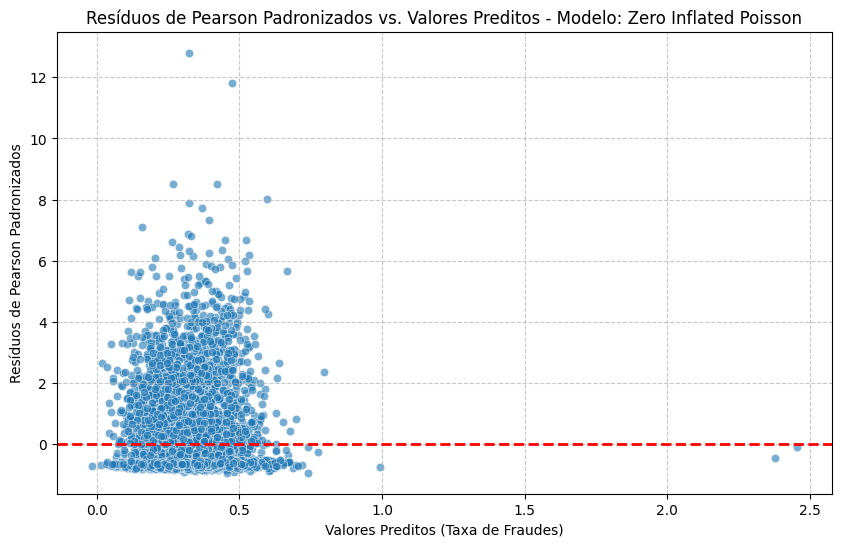

In [366]:
overdisp_plot(modelo_zip_stepwise, 'Zero Inflated Poisson')

In [367]:
lrtest([modelo_zip_stepwise, modelo_zip_stepwise])

Likelihood Ratio Test:
-2.(LL0-LLm): -0.0
p-value: 1.000

==================Result======================== 

H0: Models with log-likelihoods that are not statistically different at 95% confidence level


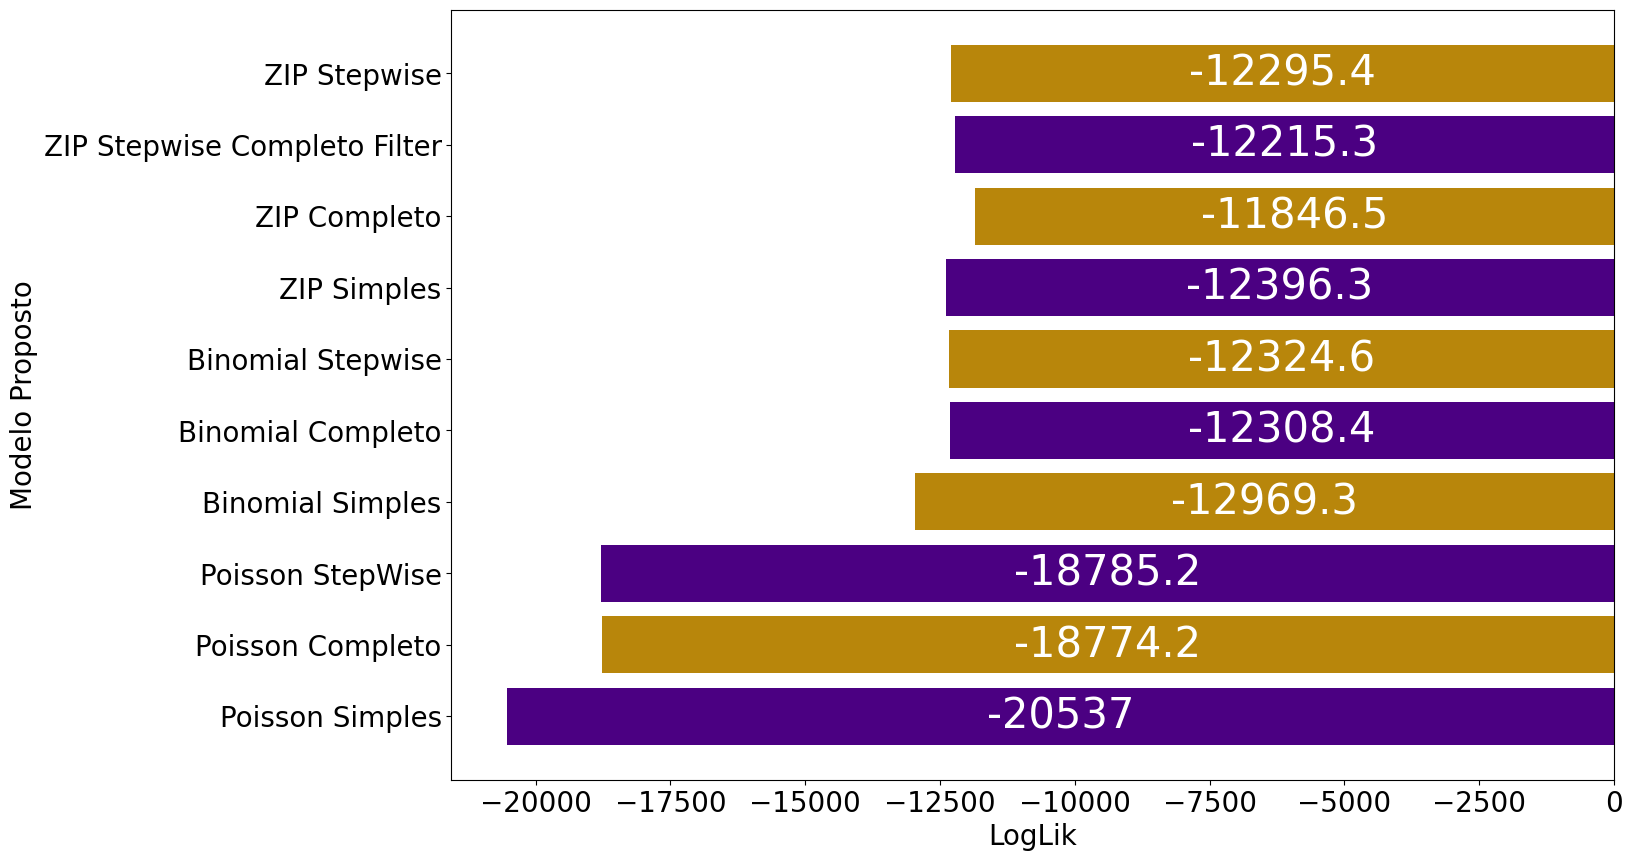

In [368]:
compare_models({
    'modelo':[
        'Poisson Simples',
        'Poisson Completo',
        'Poisson StepWise',
        'Binomial Simples',
        'Binomial Completo',
        'Binomial Stepwise',
        'ZIP Simples',
        'ZIP Completo',
        'ZIP Stepwise Completo Filter',
        'ZIP Stepwise'
    ],
    'loglik':[
        modelo_poison_simple.llf,
        modelo_poison_complete.llf,
        modelo_poisson_stepswise.llf,
        modelo_binomialneg_simples.llf,
        modelo_binomialneg_completo.llf,
        modelo_binomialneg_stepwise.llf,
        modelo_zip_simples.llf,
        modelo_zip_complete.llf,
        modelo_zip_complete_filter.llf,
        modelo_zip_stepwise.llf
      ]
})

### ZINB - Zero Inflated Negative Benomial

In [380]:
result_tests = {}
for column in X_scaler.columns:
  X1 = X_scaler[column]
  X1 = sm.add_constant(X1)

  modelo_zbneg_test = sm.ZeroInflatedNegativeBinomialP(y, X1, exog_infl=X1, inflation='probit', p=1).fit(disp=False, cov_type='HC0')
  result_tests[column] = modelo_zbneg_test.prsquared

column_max = list(result_tests.keys())[np.argmax(list(result_tests.values()))]
column_max

'transactions'

In [381]:
X1 = X_scaler[column_max].copy()
X1 = sm.add_constant(X1)

In [382]:
modelo_zinb_simples = ZeroInflatedNegativeBinomialP(y, X1, exog_infl=X1, inflation='probit', p=1).fit(disp=False, cov_type='HC0')
modelo_zinb_simples.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     ZeroInflatedNegativeBinomialP Regression Results                    
=========================================================================================
Dep. Variable:                            frauds   No. Observations:                 7182
Model:             ZeroInflatedNegativeBinomialP   Df Residuals:                     7180
Method:                                      MLE   Df Model:                            1
Date:                           Sat, 31 May 2025   Pseudo R-squ.:                0.009504
Time:                                   02:42:11   Log-Likelihood:                -11108.
converged:                                  True   LL-Null:                       -11214.
Covariance Type:                             HC0   LLR p-value:                 2.809e-48
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
inflate_const            0.1114      0.029      3.784      0.000       0.054       0.169
inflate_transactions     0.0843      0.031      2.714      0.007       0.023       0.145
const                    1.3243      0.031     42.750      0.000       1.264       1.385
transactions             0.3836      0.035     11.120      0.000       0.316       0.451
alpha                    3.0083      0.157     19.152      0.000       2.700       3.316
========================================================================================
"""

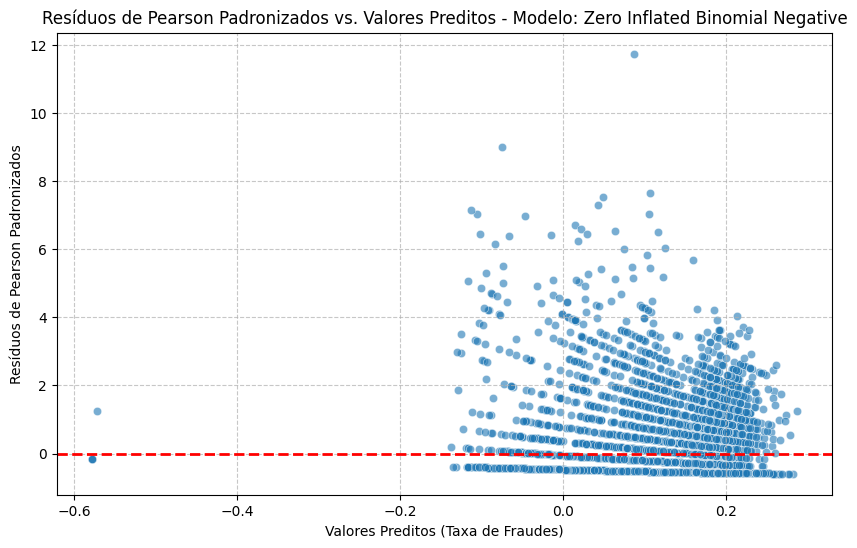

In [383]:
overdisp_plot(modelo_zinb_simples, 'Zero Inflated Binomial Negative')

In [384]:
vuong_test(modelo_binomialneg_simples, modelo_zinb_simples)

Optimization terminated successfully.
         Current function value: 1.581846
         Iterations: 28
         Function evaluations: 29
         Gradient evaluations: 29
Vuong Non-Nested Hypothesis Test-Statistic (Raw):
Vuong z-statistic: -10.903
p-value: 0.000

==================Result======================== 

H1: Indicates inflation of zeros at 95% confidence level


In [385]:
X1 = X_scaler.copy(deep=True)
X1 = sm.add_constant(X1)

In [386]:
modelo_zinb_complete = ZeroInflatedNegativeBinomialP(y, X1, exog_infl=X1, inflation='probit', p=1).fit(disp=False, cov_type='HC0')
modelo_zinb_complete.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     ZeroInflatedNegativeBinomialP Regression Results                    
=========================================================================================
Dep. Variable:                            frauds   No. Observations:                 7182
Model:             ZeroInflatedNegativeBinomialP   Df Residuals:                     7129
Method:                                      MLE   Df Model:                           52
Date:                           Sat, 31 May 2025   Pseudo R-squ.:                 0.04017
Time:                                   02:44:19   Log-Likelihood:                -10764.
converged:                                 False   LL-Null:                       -11214.
Covariance Type:                             HC0   LLR p-value:                3.253e-155
===================================================================================================================
                                                      coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------
inflate_const                                       0.0751      0.054      1.386      0.166      -0.031       0.181
inflate_transactions                               -0.0341      0.057     -0.600      0.549      -0.145       0.077
inflate_mean_amount                                -0.1574      0.266     -0.591      0.554      -0.679       0.364
inflate_std_amount                                 -0.0611      0.069     -0.879      0.379      -0.197       0.075
inflate_skew_amount                                 0.0642      0.042      1.533      0.125      -0.018       0.146
inflate_mean_current_age                           -0.2588      0.044     -5.856      0.000      -0.345      -0.172
inflate_std_current_age                             0.1604      0.036      4.482      0.000       0.090       0.231
inflate_skew_current_age                           -0.1147      0.029     -3.949      0.000      -0.172      -0.058
inflate_mean_per_capita_income                     -0.0644      0.055     -1.180      0.238      -0.171       0.042
inflate_std_per_capita_income                      -0.0143      0.068     -0.210      0.833      -0.147       0.119
inflate_skew_per_capita_income                      0.0356      0.052      0.689      0.491      -0.066       0.137
inflate_mean_total_debt                             0.0158      0.057      0.278      0.781      -0.096       0.128
inflate_std_total_debt                              0.0382      0.058      0.660      0.509      -0.075       0.152
inflate_skew_total_debt                            -0.0160      0.044     -0.369      0.712      -0.101       0.069
inflate_mean_credit_score                          -0.0439      0.027     -1.617      0.106      -0.097       0.009
inflate_std_credit_score                            0.0023      0.029      0.079      0.937      -0.054       0.058
inflate_skew_credit_score                           0.0485      0.024      1.985      0.047       0.001       0.096
inflate_mean_num_credit_cards                      -0.0533      0.034     -1.558      0.119      -0.120       0.014
inflate_std_num_credit_cards                        0.0431      0.029      1.499      0.134      -0.013       0.099
inflate_skew_num_credit_cards                       0.0122      0.031      0.390      0.697      -0.049       0.074
inflate_mean_credit_limit                           0.2215      0.056      3.929      0.000       0.111       0.332
inflate_std_credit_limit                           -0.1410      0.066     -2.151      0.031      -0.269      -0.013
inflate_skew_credit_limit                           0.0946      0.050      1.906      0.057      -0.003       0.192
inflate_use_chip_online_transaction                -0.1559      0.185     -0.842      0.400      -0.519       0.207
inflate_us

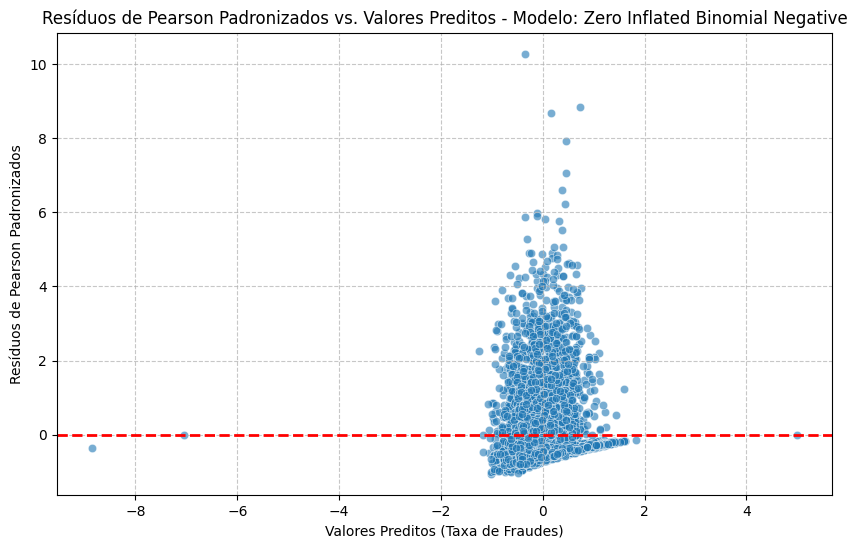

In [387]:
overdisp_plot(modelo_zinb_complete, 'Zero Inflated Binomial Negative')

In [388]:
df_features_zinp_complete = modelo_zinb_complete.pvalues.where(lambda x: x < 0.05).dropna().reset_index().rename(columns={'index':'Features', 0:'P-Value'})
feature_exog = list(filter(lambda x: x not in ['const', 'alpha'], df_features_zinp_complete.query('~Features.str.contains("inflate_")')['Features'].apply(lambda x: str(x).replace('inflate_','')).to_list()))
print('Exogenas')
print(feature_exog)
feature_exog_inflate = list(filter(lambda x: x not in ['const', 'alpha'], df_features_zinp_complete.query('Features.str.contains("inflate_")')['Features'].apply(lambda x: str(x).replace('inflate_','')).to_list()))
print('Exogenas Inflado')
print(feature_exog_inflate)

Exogenas
['transactions', 'skew_credit_score', 'mean_num_credit_cards', 'card_brand_discover', 'card_brand_mastercard', 'category_retail_specialty', 'category_government_utilities', 'category_retail_general_department', 'category_personal_services']
Exogenas Inflado
['mean_current_age', 'std_current_age', 'skew_current_age', 'skew_credit_score', 'mean_credit_limit', 'std_credit_limit', 'card_brand_visa', 'card_brand_discover', 'card_brand_mastercard', 'category_travel_hospitality', 'category_arts_entertainment_recreation']


In [390]:
X1 = X_scaler[feature_exog].copy()
X1 = sm.add_constant(X1)

X2 = X_scaler[feature_exog_inflate].copy()
X2 = sm.add_constant(X2)

modelo_zinb_complete_filter = ZeroInflatedNegativeBinomialP(y, X1, exog_infl=X1, inflation='probit', p=1).fit(disp=False, cov_type='HC0')
modelo_zinb_complete_filter.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     ZeroInflatedNegativeBinomialP Regression Results                    
=========================================================================================
Dep. Variable:                            frauds   No. Observations:                 7182
Model:             ZeroInflatedNegativeBinomialP   Df Residuals:                     7172
Method:                                      MLE   Df Model:                            9
Date:                           Sat, 31 May 2025   Pseudo R-squ.:                 0.01591
Time:                                   02:45:48   Log-Likelihood:                -11036.
converged:                                 False   LL-Null:                       -11214.
Covariance Type:                             HC0   LLR p-value:                 2.142e-71
==============================================================================================================
                                                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------
inflate_const                                  0.1120      0.029      3.882      0.000       0.055       0.169
inflate_transactions                           0.0059      0.036      0.162      0.872      -0.065       0.077
inflate_skew_credit_score                      0.0086      0.020      0.440      0.660      -0.030       0.047
inflate_mean_num_credit_cards                 -0.0697      0.023     -2.981      0.003      -0.116      -0.024
inflate_card_brand_discover                    0.0339      0.020      1.670      0.095      -0.006       0.074
inflate_card_brand_mastercard                  0.0281      0.023      1.229      0.219      -0.017       0.073
inflate_category_retail_specialty             -0.0969      0.031     -3.136      0.002      -0.157      -0.036
inflate_category_government_utilities         -0.0092      0.021     -0.445      0.656      -0.050       0.031
inflate_category_retail_general_department     0.0223      0.027      0.826      0.409      -0.031       0.075
inflate_category_personal_services            -0.0030      0.022     -0.140      0.889      -0.045       0.039
const                                          1.2977      0.030     42.681      0.000       1.238       1.357
transactions                                   0.4682      0.041     11.334      0.000       0.387       0.549
skew_credit_score                              0.0897      0.022      4.114      0.000       0.047       0.132
mean_num_credit_cards                          0.1129      0.028      3.965      0.000       0.057       0.169
card_brand_discover                            0.0429      0.022      1.983      0.047       0.000       0.085
card_brand_mastercard                          0.0774      0.024      3.179      0.001       0.030       0.125
category_retail_specialty                      0.1174      0.035      3.372      0.001       0.049       0.186
category_government_utilities                 -0.0533      0.022     -2.372      0.018      -0.097      -0.009
category_retail_general_department             0.1320      0.027      4.847      0.000       0.079       0.185
category_personal_services                    -0.0820      0.023     -3.502      0.000      -0.128      -0.036
alpha                                          2.8446      0.149     19.093      0.000       2.553       3.137
==============================================================================================================
"""

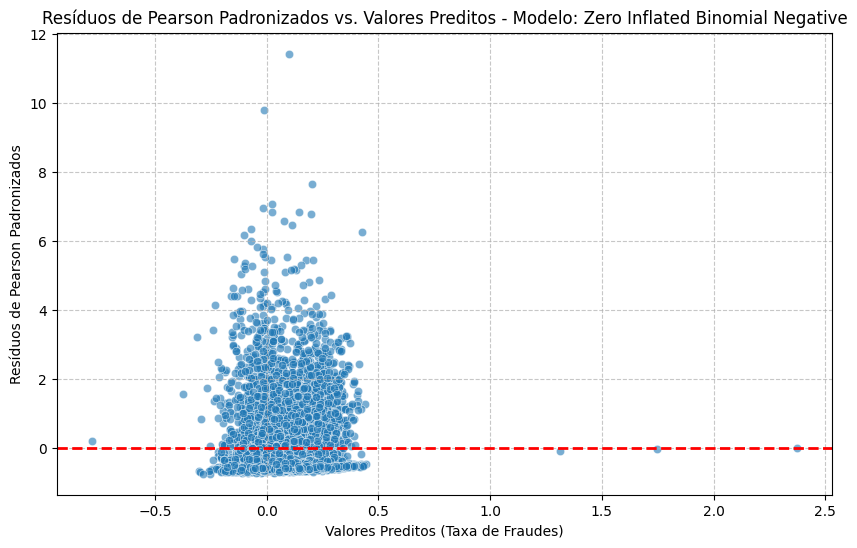

In [391]:
overdisp_plot(modelo_zinb_complete_filter, 'Zero Inflated Binomial Negative')

In [392]:
step_wise = StepwiseZeroInflated(alpha=0.05, model_type='ZINB', verbose=True, selection_criterion='AIC', model_params=dict(inflation='probit', p=1), fit_params=dict(cov_type='HC0', disp=False))
step_wise.fit(X_scaler, y)

INICIANDO PROCESSO STEPWISE
Modelo: ZINB
Critério de seleção: AIC
Features disponíveis: 52
Dataset: 7182 observações, 4556 zeros (63.4%)
--------------------------------------------------------------------------------
Modelo baseline ajustado:
  - Observações: 7182
  - Zeros: 4556 (63.4%)
  - AIC baseline: 22434.79
  - Convergiu: True
AIC inicial (modelo nulo): 22434.79
--------------------------------------------------------------------------------

ITERAÇÃO 1/100
Processo Forward Selection: Testando features candidatas para inclusão no modelo
Status atual: 0 exógenas, 0 inflacionadas, 0 excluídas

Testando feature: 'transactions'
Critério de significância: p-valor < 0.05
    MOMENTO 1 - Validação inicial de significância
    INICIAL - Todas features significativas (p < 0.05)
    MOMENTO 2 - Pulado (apenas uma feature ou validação desabilitada)
    MOMENTO 3 - Validação final robusta
        Executando validação final robusta
    FINAL - Todas features significativas (p < 0.05)
      

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


    MOMENTO 1 - Validação inicial de significância
    INICIAL - Todas features significativas (p < 0.05)
    MOMENTO 2 - Validação de estabilidade
        Testando estabilidade com 7 features
        Feature 'transactions' essencial (ΔAIC: 149.65)
        Feature 'online_sales_no' essencial (ΔAIC: 46.61)
        Modelo estável com todas as features
    MOMENTO 3 - Validação final robusta
        Executando validação final robusta
    FINAL - Todas features significativas (p < 0.05)
        Validação final aprovada (AIC: 22161.51)
    APROVADA em todos os momentos!
    Feature será INCLUÍDA no modelo (AIC: 22161.51)
EXÓGENA: AIC = 22161.51 (melhoria: 1.68)
    MOMENTO 1 - Validação inicial de significância
    INICIAL - Features com p >= 0.05: std_current_age (inf, p=0.0552)
    REJEITADA no Momento 1: features não significativas (inicial): std_current_age (inf, p=0.0552)
    MODELO MANTIDO INTACTO (feature não incluída)
INFLACIONADA: rejeitada (Momento 1 - features não significativas 

StepwiseZeroInflated(fit_params={'cov_type': 'HC0', 'disp': False},
                     model_params={'inflation': 'probit', 'p': 1},
                     model_type='ZINB', verbose=True)

In [393]:
modelo_zinb_stepwise = step_wise.final_model_
modelo_zinb_stepwise.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     ZeroInflatedNegativeBinomialP Regression Results                    
=========================================================================================
Dep. Variable:                                 y   No. Observations:                 7182
Model:             ZeroInflatedNegativeBinomialP   Df Residuals:                     7175
Method:                                      MLE   Df Model:                            6
Date:                           Sat, 31 May 2025   Pseudo R-squ.:                 0.01339
Time:                                   03:01:23   Log-Likelihood:                -11064.
converged:                                  True   LL-Null:                       -11214.
Covariance Type:                             HC0   LLR p-value:                 7.321e-62
======================================================================================================
                                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
inflate_const                          0.1241      0.024      5.131      0.000       0.077       0.172
inflate_std_current_age                0.0462      0.022      2.101      0.036       0.003       0.089
inflate_mean_credit_score             -0.0569      0.022     -2.534      0.011      -0.101      -0.013
inflate_category_personal_services     0.0442      0.018      2.450      0.014       0.009       0.080
const                                  1.3165      0.027     49.483      0.000       1.264       1.369
transactions                           0.3047      0.028     10.991      0.000       0.250       0.359
std_amount                             0.0706      0.023      3.060      0.002       0.025       0.116
std_per_capita_income                 -0.0424      0.021     -2.062      0.039      -0.083      -0.002
online_sales_no                       -0.1678      0.022     -7.707      0.000      -0.210      -0.125
category_construction_contractors     -0.0325      0.010     -3.339      0.001      -0.052      -0.013
category_financial_insurance          -0.0516      0.022     -2.387      0.017      -0.094      -0.009
alpha                                  2.9233      0.151     19.370      0.000       2.628       3.219
======================================================================================================
"""

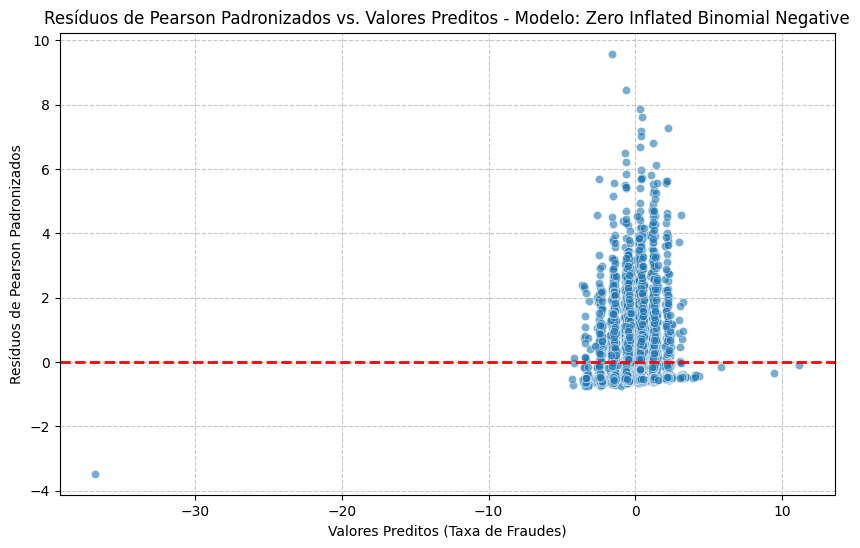

In [394]:
overdisp_plot(modelo_zinb_stepwise, 'Zero Inflated Binomial Negative')

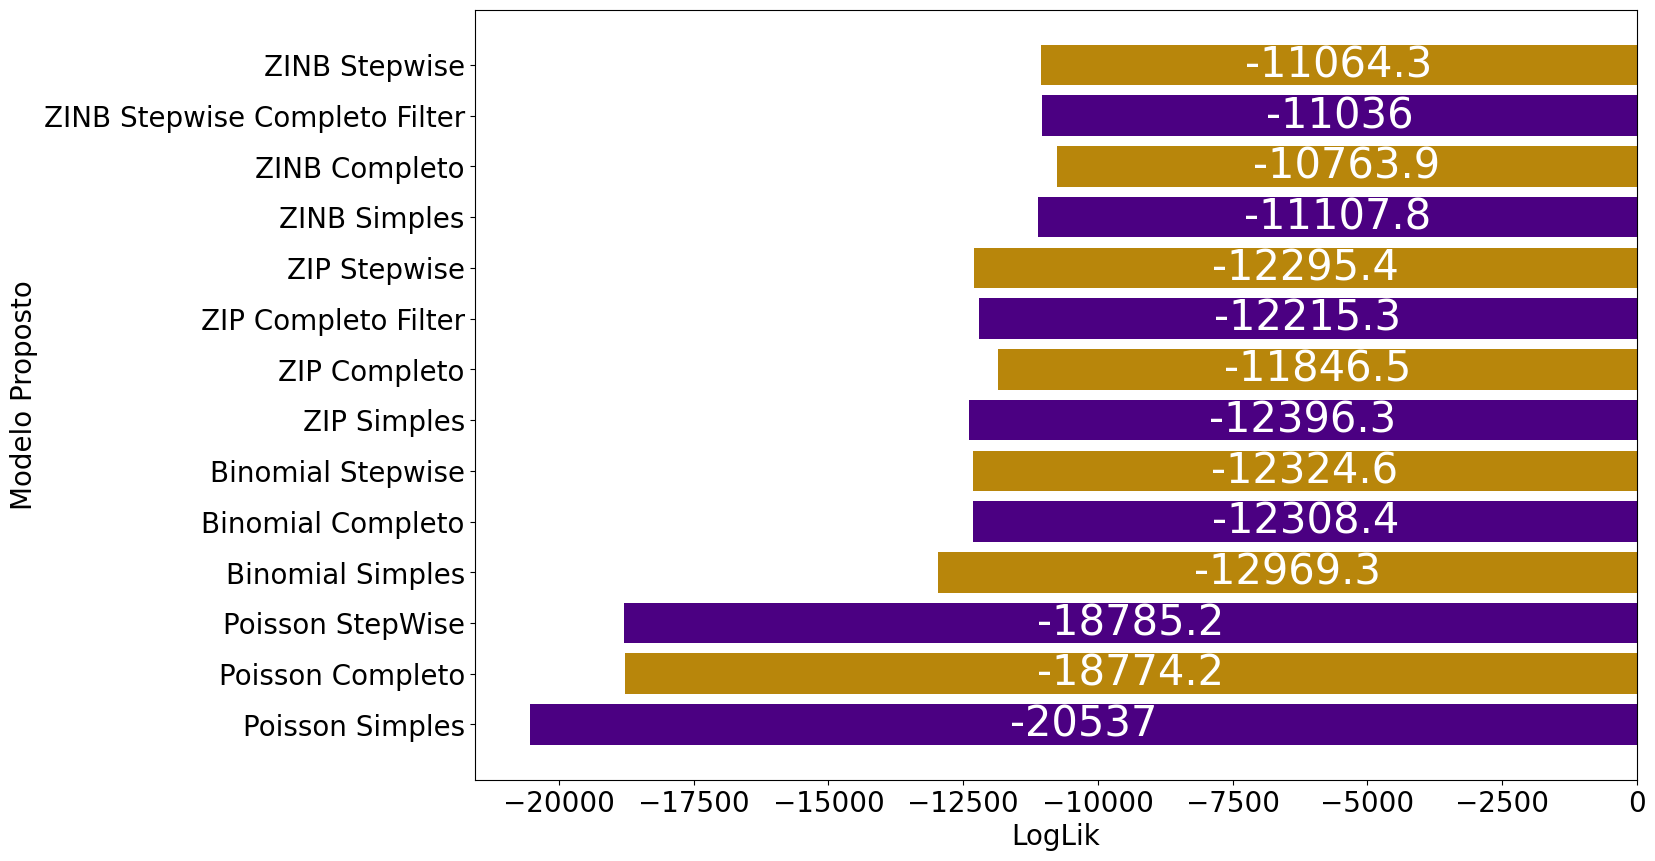

In [395]:
compare_models({
    'modelo':[
        'Poisson Simples',
        'Poisson Completo',
        'Poisson StepWise',
        'Binomial Simples',
        'Binomial Completo',
        'Binomial Stepwise',
        'ZIP Simples',
        'ZIP Completo',
        'ZIP Completo Filter',
        'ZIP Stepwise',
        'ZINB Simples',
        'ZINB Completo',
        'ZINB Stepwise Completo Filter',
        'ZINB Stepwise'
    ],
    'loglik':[
        modelo_poison_simple.llf,
        modelo_poison_complete.llf,
        modelo_poisson_stepswise.llf,
        modelo_binomialneg_simples.llf,
        modelo_binomialneg_completo.llf,
        modelo_binomialneg_stepwise.llf,
        modelo_zip_simples.llf,
        modelo_zip_complete.llf,
        modelo_zip_complete_filter.llf,
        modelo_zip_stepwise.llf,
        modelo_zinb_simples.llf,
        modelo_zinb_complete.llf,
        modelo_zinb_complete_filter.llf,
        modelo_zinb_stepwise.llf
      ]
})

In [396]:
titles = [
  'Poisson Simples',
  'Poisson Completo',
  'Poisson StepWise',
  'Binomial Simples',
  'Binomial Completo',
  'Binomial Stepwise',
  'ZIP Simples',
  'ZIP Completo',
  'ZIP Completo Filter',
  'ZIP Stepwise',
  'ZIMB Simples',
  'ZIMB Completo',
  'ZIMB Completo Filter',
  'ZIMB Stepwise',
]
models = [
    modelo_poison_simple,
    modelo_poison_complete,
    modelo_poisson_stepswise,
    modelo_binomialneg_simples,
    modelo_binomialneg_completo,
    modelo_binomialneg_stepwise,
    modelo_zip_simples,
    modelo_zip_complete,
    modelo_zip_complete_filter,
    modelo_zip_stepwise,
    modelo_zinb_simples,
    modelo_zinb_complete,
    modelo_zinb_complete_filter,
    modelo_zinb_stepwise
]

In [397]:
metrics = []
for title, model in zip(titles, models):
  metric = dict(title=title, LLF=model.llf, BIC=model.bic, AIC=model.aic)

  if np.isnan(model.llf):
    continue

  if hasattr(model, 'prsquared'):
    metric['PseudoR2'] = model.prsquared
  else:
    metric['PseudoR2'] = model.pseudo_rsquared()

  metrics.append(metric)

In [398]:
df_metrics = pd.DataFrame(metrics)
df_metrics.sort_values(by='AIC')

title           LLF           BIC           AIC  PseudoR2
11         ZIMB Completo -10763.857702  22477.804054  21741.715404  0.040175
12  ZIMB Completo Filter -11035.960901  22258.387799  22113.921803  0.015911
13         ZIMB Stepwise -11064.280703  22235.113404  22152.561406  0.013386
10          ZIMB Simples -11107.813569  22260.023804  22225.627138  0.009504
7           ZIP Completo -11846.491068  24634.191452  23904.982136  0.056621
8    ZIP Completo Filter -12215.287884  24634.800430  24476.575767  0.027252
9           ZIP Stepwise -12295.381389  24741.711442  24624.762778  0.020874
5      Binomial Stepwise -12324.578150 -51563.398213  24717.156301  0.187145
4      Binomial Completo -12308.393450 -51364.904952  24736.786900  0.190800
6            ZIP Simples -12396.316241  24828.149814  24800.632482  0.012836
3       Binomial Simples -12969.322412 -50558.048351  25942.644825  0.027279
2       Poisson StepWise -18785.234676 -34130.718176  37654.469352  0.426625
1       Poisson Completo -18774.235713 -33992.888106  37668.471426  0.428379
0        Poisson Simples -20536.991422 -30982.378013  41077.982843  0.066111

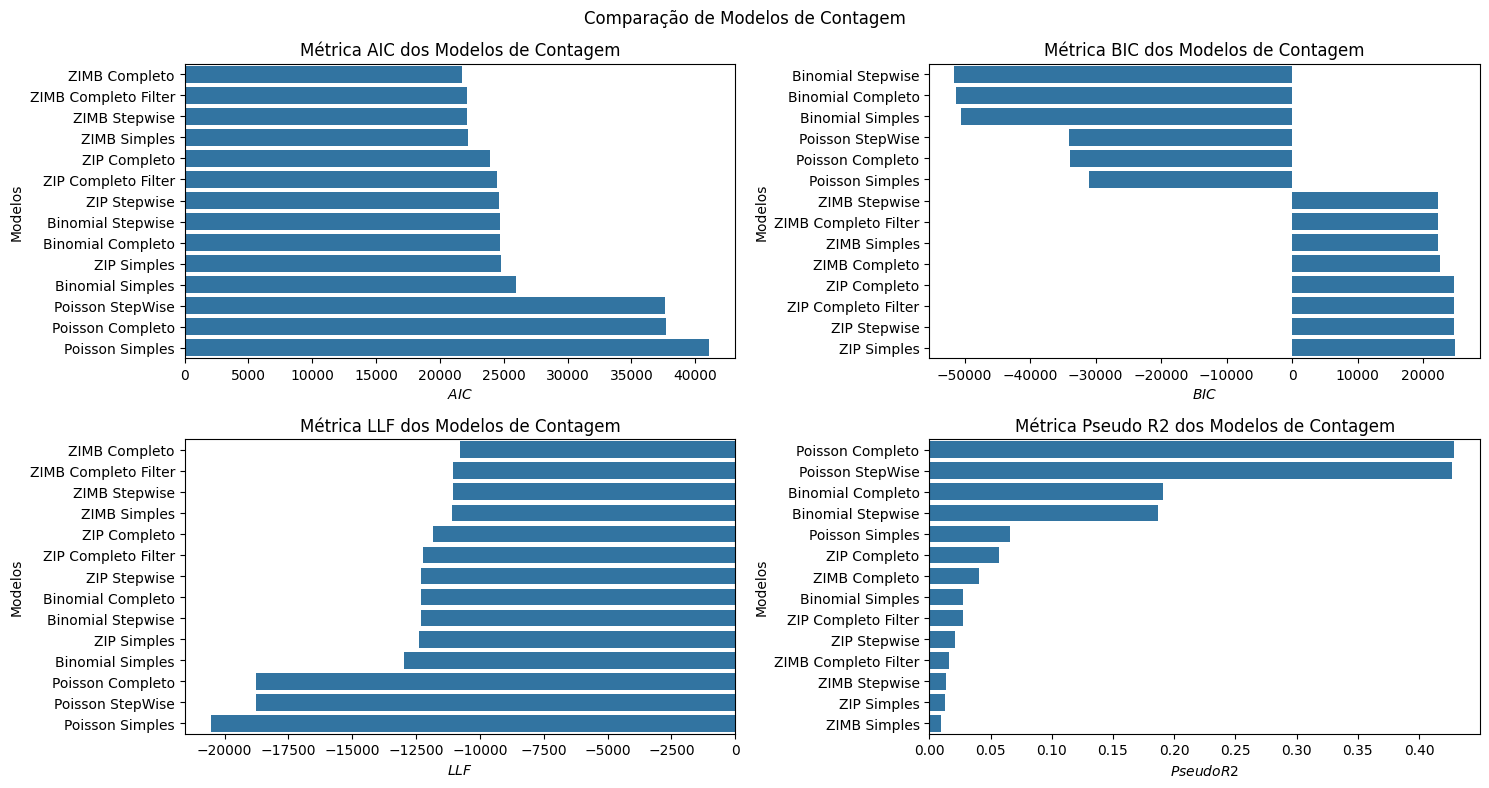

In [399]:
plt.figure(figsize=(15,8))
plt.suptitle('Comparação de Modelos de Contagem')

plt.subplot(2,2,1)
plt.title('Métrica AIC dos Modelos de Contagem')
sns.barplot(data=df_metrics.sort_values(by=['AIC', 'title'], ascending=True), y='title', x='AIC')
plt.xlabel('$AIC$')
plt.ylabel('Modelos')

plt.subplot(2,2,2)
plt.title('Métrica BIC dos Modelos de Contagem')
sns.barplot(data=df_metrics.sort_values(['BIC', 'title'], ascending=True), y='title', x='BIC')
plt.xlabel('$BIC$')
plt.ylabel('Modelos')

plt.subplot(2,2,3)
plt.title('Métrica LLF dos Modelos de Contagem')
sns.barplot(data=df_metrics.sort_values(['LLF', 'title'], ascending=False), y='title', x='LLF')
plt.xlabel('$LLF$')
plt.ylabel('Modelos')

plt.subplot(2,2,4)
plt.title('Métrica Pseudo R2 dos Modelos de Contagem')
sns.barplot(data=df_metrics.sort_values(['PseudoR2', 'title'], ascending=False), y='title', x='PseudoR2')
plt.xlabel('$Pseudo R2$')
plt.ylabel('Modelos')

plt.tight_layout()
plt.show()

In [400]:
metrics_titles = []
metrics_mse = []
metrics_rmse = []

In [401]:
for title, model in zip(titles, models):

    if np.isnan(model.llf):
      continue

    metrics_titles.append(title)
    metrics_mse.append(mean_squared_error(y.loc[model.fittedvalues.index], round(model.fittedvalues)))
    metrics_rmse.append(root_mean_squared_error(y.loc[model.fittedvalues.index], round(model.fittedvalues)))

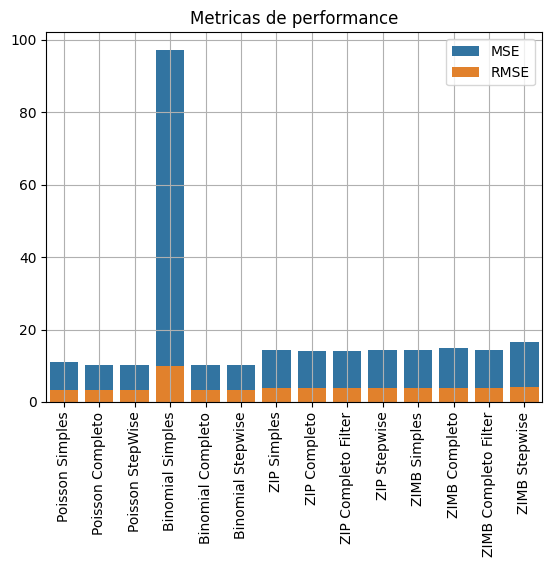

In [402]:
plt.title('Metricas de performance')
sns.barplot(x=metrics_titles, y=metrics_mse, label='MSE')
sns.barplot(x=metrics_titles, y=metrics_rmse, label='RMSE')
plt.legend()
plt.grid()
plt.xticks(rotation=90)
plt.show()

In [403]:
df_predict_models = pd.concat([model.fittedvalues for model in models], axis=1)
df_predict_models.columns = titles

for column in df_predict_models.columns:
  df_predict_models[column] = df_predict_models[column].apply(lambda x: 0 if np.isnan(x) or int(round(x))< 0 else int(round(x)))

df_predict_models['Target'] = y
df_predict_models.head()

Poisson Simples  Poisson Completo  Poisson StepWise  Binomial Simples  \
0                1                 2                 2                 2   
1                1                 5                 5                 3   
2                1                 2                 2                 2   
3                1                 2                 2                 2   
4                1                 3                 3                 1   

   Binomial Completo  Binomial Stepwise  ZIP Simples  ZIP Completo  \
0                  2                  2            0             0   
1                  6                  5            0             0   
2                  2                  2            1             0   
3                  2                  2            0             0   
4                  3                  3            0             0   

   ZIP Completo Filter  ZIP Stepwise  ZIMB Simples  ZIMB Completo  \
0                    1             0             0              0   
1                    0             0             0              0   
2                    1             1             0              0   
3                    1             0             0              0   
4                    1             0             0              0   

   ZIMB Completo Filter  ZIMB Stepwise  Target  
0                     0              0       0  
1                     0              0       1  
2                     0              0       0  
3                     0              0       0  
4                     0              1       0

In [404]:
df_resume = df_predict_models['Target'].value_counts().reset_index()
df_resume.columns = ['Target', 'Quantidade']
df_resume = df_resume.sort_values(by='Target').reset_index(drop=True)
df_resume.head()

Target  Quantidade
0       0        4556
1       1         549
2       2         381
3       3         289
4       4         259

In [405]:
resumes = [df_resume]
for column in titles:
  df_resume = df_predict_models.assign(ok=lambda x: x['Target'] == x[column]).groupby('Target').agg({'ok':'sum'}).reset_index()
  df_resume.columns = ['Target', column]
  df_resume.drop(columns='Target', inplace=True)
  resumes.append(df_resume)
df_resume = pd.concat(resumes, axis=1)

In [406]:
df_resume

Target  Quantidade  Poisson Simples  Poisson Completo  Poisson StepWise  \
0        0        4556                0               214               212   
1        1         549              257               236               238   
2        2         381              192               136               137   
3        3         289                0                47                46   
4        4         259                0                18                17   
5        5         223                0                 3                 4   
6        6         193                0                 1                 1   
7        7         173                0                 0                 0   
8        8         116                0                 0                 0   
9        9          97                0                 0                 0   
10      10          93                0                 0                 0   
11      11          78                0                 0                 0   
12      12          53                0                 0                 0   
13      13          27                0                 0                 0   
14      14          31                0                 0                 0   
15      15          15                0                 0                 0   
16      16          17                0                 0                 0   
17      17           6                0                 0                 0   
18      18           8                0                 0                 0   
19      19           7                0                 0                 0   
20      20           3                0                 0                 0   
21      21           1                0                 0                 0   
22      22           2                0                 0                 0   
23      23           2                0                 0                 0   
24      24           1                0                 0                 0   
25      26           1                0                 0                 0   
26      37           1                0                 0                 0   

    Binomial Simples  Binomial Completo  Binomial Stepwise  ZIP Simples  \
0                  2                291                271         4485   
1                170                232                239            8   
2                247                126                132            0   
3                 14                 52                 51            0   
4                  1                 23                 20            0   
5                  0                  6                  7            0   
6                  0                  3                  3            0   
7                  0                  0                  0            0   
8                  0                  0                  0            0   
9                  0                  0                  0            0   
10                 0                  0                  0            0   
11                 0                  0                  0            0   
12                 0                  0                  0            0   
13                 0                  0                  0            0   
14                 0                  0                  0            0   
15                 0                  0                  0            0   
16                 0                  0                  0            0   
17                 0                  0                  0            0   
18                 0                  0                  0            0   
19                 0                  0                  0            0   
20                 0                  0                  0            0   
21                 0                  0                  0            0   
22                 0                  0                  0        

In [ ]:
df_resume_percent = df_resume.copy()
for column in titles:
  df_resume_percent[column] = round(df_resume_percent[column] / df_resume_percent['Quantidade'], 2)
df_resume_percent

Target  Quantidade  Poisson Simples  Poisson Completo  Poisson StepWise  \
0        0       11006             0.32              0.45              0.45   
1        1         975             0.77              0.46              0.46   
2        2         646             0.00              0.28              0.27   
3        3         393             0.00              0.02              0.03   
4        4         304             0.00              0.00              0.00   
5        5         257             0.00              0.00              0.00   
6        6         177             0.00              0.00              0.00   
7        7         163             0.00              0.00              0.00   
8        8         111             0.00              0.00              0.00   
9        9          88             0.00              0.00              0.00   
10      10          69             0.00              0.00              0.00   
11      11          55             0.00              0.00              0.00   
12      12          37             0.00              0.00              0.00   
13      13          23             0.00              0.00              0.00   
14      14          17             0.00              0.00              0.00   
15      15          14             0.00              0.00              0.00   
16      16           8             0.00              0.00              0.00   
17      17           2             0.00              0.00              0.00   
18      18           8             0.00              0.00              0.00   
19      19           5             0.00              0.00              0.00   
20      20           1             0.00              0.00              0.00   
21      21           1             0.00              0.00              0.00   
22      23           1             0.00              0.00              0.00   
23      26           1             0.00              0.00              0.00   
24      35           1             0.00              0.00              0.00   

    Binomial Simples  Binomial Completo  Binomial Stepwise  ZIP Simples  \
0               0.32               0.46               0.46         0.00   
1               0.77               0.44               0.44         0.77   
2               0.00               0.27               0.27         0.17   
3               0.00               0.03               0.03         0.00   
4               0.00               0.00               0.00         0.00   
5               0.00               0.00               0.00         0.00   
6               0.00               0.00               0.00         0.00   
7               0.00               0.00               0.00         0.00   
8               0.00               0.00               0.00         0.00   
9               0.00               0.00               0.00         0.00   
10              0.00               0.00               0.00         0.00   
11              0.00               0.00               0.00         0.00   
12              0.00               0.00               0.00         0.00   
13              0.00               0.00               0.00         0.00   
14              0.00               0.00               0.00         0.00   
15              0.00               0.00               0.00         0.00   
16              0.00               0.00               0.00         0.00   
17              0.00               0.00               0.00         0.00   
18              0.00               0.00               0.00         0.00   
19              0.00               0.00               0.00         0.00   
20              0.00               0.00               0.00         0.00   
21              0.00               0.00               0.00         0.00   
22              0.00               0.00               0.00         0.00   
23              0.00               0.00               0.00         0.00   
24              0.00               0.00               0.00         0.00   

In [407]:
df_resume_percent[titles].apply(lambda x: (len([xi for xi in x if xi > 0])/len(x)) * x.sum(), axis=0).sort_values(ascending=False)

Binomial Stepwise       0.300741
Binomial Completo       0.292963
Poisson StepWise        0.285185
Poisson Completo        0.282593
ZIMB Stepwise           0.124444
Binomial Simples        0.112222
ZIMB Completo           0.092222
ZIP Completo Filter     0.075556
ZIMB Completo Filter    0.074815
ZIP Stepwise            0.074074
ZIP Simples             0.073333
Poisson Simples         0.071852
ZIP Completo            0.062222
ZIMB Simples            0.000370
dtype: float64